<a href="https://colab.research.google.com/github/scaairesearch/da_bias_demo/blob/main/demo_bias_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Demo app to mitigate bias



## **Updated to create more conditions**

1.   Find the list of image names - folder structure for a specific condition : Done for some conditions - done
2.   Find conditions - pickle the dataframe / list of images
3.   Create a generic data loader to give images for specific condition (works on based on list of image, image path provided) - use class DatasetEXPWIMAGECROPRACE(Dataset): done
4.   Download model - all 3 - done
5.   Run inference on the images based on dataloader - done
6.   Develop gradio app - done
7.   deploy gradio app
8.   Running from a saved location
9.   For all conditions, get the file names, and save them in a folder
10.  Save each conditional dataframes
11.  read data from dataframes, create dataloader using folder


### Installing and importing Libraries

In [ ]:
!pip install --quiet facenet-pytorch gradio pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.

In [ ]:
!pip install --upgrade Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 10.4.0 which is incompatible.


In [ ]:
# install general libraries #OK
import os
# import zipfile

import torch.nn as nn
import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau


import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

# from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision import transforms
import torch
from PIL import Image
from facenet_pytorch import MTCNN

from torch.autograd import Function
import torch.nn.functional as F
import gradio as gr
from collections import OrderedDict
from copy import deepcopy
import cv2


In [ ]:
# check for cuda #OK
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

 Cuda Status : False
cpu


In [ ]:
mtcnn = MTCNN(image_size=224, device= device) # default is 224, now no need to mention later on #OK

In [ ]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

### Loading CSV Files
These are result files based on validation results

In [ ]:
# base_dir = ""
non_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])
dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])
ewc_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_23_05_wo_se_a.csv').sort_values(by=['image'])

In [ ]:
# Rename the last column in each dataframe
non_dann_result.rename(columns={'p_emotion': 'p_emotion_non_dann'}, inplace=True)
dann_result.rename(columns={'p_emotion': 'p_emotion_dann'}, inplace=True)
ewc_dann_result.rename(columns={'p_emotion': 'p_emotion_ewc_dann'}, inplace=True)

In [ ]:
non_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion_non_dann
167,167,afraid_African_214.jpg,Fear,African,Fear
2502,2502,afraid_american_238.jpg,Surprise,African,Fear
2069,2069,afraid_asian_103.jpg,Happy,Asian,Angry
1006,1006,afraid_asian_336.jpg,Surprise,Asian,Neutral
2424,2424,afraid_asian_367.jpg,Surprise,Asian,Neutral
...,...,...,...,...,...
4325,4325,unhappy_expression_537.jpg,Happy,White,Sad
2049,2049,unhappy_expression_643.jpg,Disgust,White,Disgust
8202,8202,unhappy_expression_730.jpg,Neutral,Asian,Disgust
8344,8344,unhappy_expression_749.jpg,Disgust,White,Happy


In [ ]:
merged_df = non_dann_result.merge(dann_result, on=['image', 'gt_emotion', 'gt_race']).merge(ewc_dann_result, on=['image', 'gt_emotion', 'gt_race'])
merged_df.shape, merged_df.columns

((8458, 9),
 Index(['Unnamed: 0_x', 'image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
        'Unnamed: 0_y', 'p_emotion_dann', 'Unnamed: 0', 'p_emotion_ewc_dann'],
       dtype='object'))

In [ ]:
merged_df.head()

,Unnamed: 0_x,image,gt_emotion,gt_race,p_emotion_non_dann,Unnamed: 0_y,p_emotion_dann,Unnamed: 0,p_emotion_ewc_dann
0,167,afraid_African_214.jpg,Fear,African,Fear,4064,Neutral,7694,Neutral
1,2502,afraid_american_238.jpg,Surprise,African,Fear,174,Neutral,293,Fear
2,2069,afraid_asian_103.jpg,Happy,Asian,Angry,4002,Angry,2763,Angry
3,1006,afraid_asian_336.jpg,Surprise,Asian,Neutral,845,Neutral,7041,Neutral
4,2424,afraid_asian_367.jpg,Surprise,Asian,Neutral,4416,Neutral,7260,Neutral


In [ ]:
merged_df = merged_df[['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann', 'p_emotion_dann', 'p_emotion_ewc_dann']]

In [ ]:
merged_df.shape, merged_df.columns,merged_df.head()

((8458, 6),
 Index(['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
        'p_emotion_dann', 'p_emotion_ewc_dann'],
       dtype='object'),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 0   afraid_African_214.jpg       Fear  African               Fear   
 1  afraid_american_238.jpg   Surprise  African               Fear   
 2     afraid_asian_103.jpg      Happy    Asian              Angry   
 3     afraid_asian_336.jpg   Surprise    Asian            Neutral   
 4     afraid_asian_367.jpg   Surprise    Asian            Neutral   
 
   p_emotion_dann p_emotion_ewc_dann  
 0        Neutral            Neutral  
 1        Neutral               Fear  
 2          Angry              Angry  
 3        Neutral            Neutral  
 4        Neutral            Neutral  )

## Dataframes based on Conditions
1. Images that are ok in non_dann, dann, dann_ewc
2. Images that are nok in non_dann, ok in dann and dann_ewc
3. Images that are nok in non_dann, nok in dann and ok in dann_ewc
4. Images that are nok in non_dann, dann_ewc but ok in dann
5. Images which are non_ok on all 3
6. Images that are ok in non_dann, but nok in dann and dann_ewc
7. Images that are ok in non_dann, dann, but nok in dann_ewc
8. Images that are ok in non_dann, dann_ewc, but nok in dann

### Condition 1: Images that are predicted same in non_dann, dann, dann_ewc, ground truth

In [ ]:
condition_1 = (merged_df['gt_emotion'] == merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])

In [ ]:
filtered_df_condition_1 = merged_df[condition_1]
filtered_df_condition_1.shape, filtered_df_condition_1.head()

((1805, 6),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 5      afraid_asian_39.jpg    Neutral    Asian            Neutral   
 32  amazed_African_145.jpg      Happy  African              Happy   
 38  amazed_African_253.jpg      Happy  African              Happy   
 40   amazed_African_28.jpg      Happy  African              Happy   
 41  amazed_African_293.jpg    Neutral  African            Neutral   
 
    p_emotion_dann p_emotion_ewc_dann  
 5         Neutral            Neutral  
 32          Happy              Happy  
 38          Happy              Happy  
 40          Happy              Happy  
 41        Neutral            Neutral  )

In [ ]:
# filtered_df_condition_1.columns

Index(['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
       'p_emotion_dann', 'p_emotion_ewc_dann'],
      dtype='object')

In [ ]:
# df_merged_per_race = merged_df.groupby('gt_race').size().reset_index(name='merged_count')

In [ ]:
# filtered_df_condition_1_per_race= filtered_df_condition_1.groupby('gt_race').size().reset_index(name='condition_1_count')

In [ ]:
# def race_proportion(base_df, condition_df, column_name = 'gt_race'):#, column_name):
#     """
#     Trying to understand the distribution of race in base df and conditional df
#     Further understanding if proportion of a race in condition and base...
#     """
#     base_df_col = f'{column_name}'+'_base'
#     condition_df_col = f'{column_name}'+'_condition'
#     base_df_per_column_name = base_df.groupby(column_name).size().reset_index(name=base_df_col)
#     condition_df_per_column_name = condition_df.groupby(column_name).size().reset_index(name=condition_df_col)
#     merged_df = base_df_per_column_name.merge(condition_df_per_column_name, on=column_name)


#     merged_df[condition_df_col] =   merged_df[condition_df_col].fillna(0)
#     # # merged_df[merged_df.columns[-1]] =   merged_df[merged_df.columns[-1]].fillna(0)
#     proportion_col = f'{column_name}'+'_proportion'
#     merged_df[proportion_col] = round(merged_df[condition_df_col] *100/ merged_df[base_df_col],2)
#     print(merged_df.head())

#     return merged_df
#     # merged_df[] = merged_df[column_name].fillna(0)
#     # print(merged_df.head())

In [ ]:
# race_proportion(merged_df, filtered_df_condition_1)

          gt_race  gt_race_base  gt_race_condition  gt_race_proportion
0         African           814                164               20.15
1           Asian          1072                212               19.78
2          Indian           580                102               17.59
3          Latino           194                 70               36.08
4  Middle Eastern           202                 33               16.34


,gt_race,gt_race_base,gt_race_condition,gt_race_proportion
0,African,814,164,20.15
1,Asian,1072,212,19.78
2,Indian,580,102,17.59
3,Latino,194,70,36.08
4,Middle Eastern,202,33,16.34
5,White,5596,1224,21.87


In [ ]:
# race_proportion(df_merged_per_race,filtered_df_condition_1_per_race)

In [ ]:
# def get_sampled_df(df,num_samples = 5):
#     sampled_df = pd.DataFrame()

#     for name, group in df.groupby('gt_race'):
#         sampled_group = group.sample(n=5, replace=True)  # replace=True to allow sampling with replacement if group has fewer than 5 rows
#         sampled_df = pd.concat([sampled_df, sampled_group], ignore_index=True)

#     return sampled_df

def stratified_sample(df, n = 42):
    # Calculate the number of samples needed for each combination of gt_race and gt_emotion
    num_races = df['gt_race'].nunique()
    num_emotions = df['gt_emotion'].nunique()

    # Calculate the number of samples needed for each combination
    samples_per_combination = max(1, n // (num_races * num_emotions))

    # Group by gt_race and gt_emotion and sample
    sampled_df = df.groupby(['gt_race', 'gt_emotion']).apply(lambda x: x.sample(samples_per_combination, replace=True)).reset_index(drop=True)

    # If we have more samples than needed, we sample again to trim down to n samples
    if len(sampled_df) > n:
        sampled_df = sampled_df.sample(n)

    return sampled_df

In [ ]:
sampled_df_condition_1 = stratified_sample(filtered_df_condition_1)

### Condition 2: Images that are nok in non_dann, ok in dann and dann_ewc

In [ ]:
condition_2 = (merged_df['gt_emotion'] != merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])

In [ ]:
filtered_df_condition_2 = merged_df[condition_2]
filtered_df_condition_2.shape, filtered_df_condition_2.head()

((278, 6),
                       image gt_emotion  gt_race p_emotion_non_dann  \
 18        afraid_man_41.jpg    Neutral  African            Disgust   
 31   amazed_African_141.jpg    Neutral  African            Disgust   
 242    amazed_black_160.jpg    Neutral  African                Sad   
 247    amazed_black_243.jpg    Neutral   Latino              Angry   
 267     amazed_boss_204.jpg      Angry    Asian              Happy   
 
     p_emotion_dann p_emotion_ewc_dann  
 18         Neutral            Neutral  
 31         Neutral            Neutral  
 242        Neutral            Neutral  
 247        Neutral            Neutral  
 267          Angry              Angry  )

In [ ]:
# sampled_df_condition_2 = get_sampled_df(filtered_df_condition_2)
sampled_df_condition_2 = stratified_sample(filtered_df_condition_2)
sampled_df_condition_2

,image,gt_emotion,gt_race,p_emotion_non_dann,p_emotion_dann,p_emotion_ewc_dann
0,awe_manager_336.jpg,Happy,African,Disgust,Happy,Happy
1,awe_family_109.jpg,Neutral,African,Surprise,Neutral,Neutral
2,angry_expression_276.jpg,Angry,Asian,Happy,Angry,Angry
3,awe_chinese_388.jpg,Happy,Asian,Disgust,Happy,Happy
4,astound_chinese_146.jpg,Neutral,Asian,Surprise,Neutral,Neutral
5,hostile_woman_32.jpg,Angry,Indian,Happy,Angry,Angry
6,anxious_grandfather_76.jpg,Fear,Indian,Neutral,Fear,Fear
7,awe_boss_527.jpg,Neutral,Indian,Disgust,Neutral,Neutral
8,awe_husband_71.jpg,Happy,Latino,Surprise,Happy,Happy
9,amazed_black_243.jpg,Neutral,Latino,Angry,Neutral,Neutral


### Condition3. Images that are nok in non_dann, nok in dann and ok in dann_ewc


In [ ]:
condition_3 = (merged_df['gt_emotion'] != merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] != merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])

In [ ]:
filtered_df_condition_3 = merged_df[condition_3]
filtered_df_condition_3.shape, filtered_df_condition_3.head()

((318, 6),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 7         afraid_boy_8.jpg       Fear    White              Angry   
 35   amazed_African_19.jpg      Happy  African           Surprise   
 39  amazed_African_256.jpg        Sad  African              Angry   
 52   amazed_African_47.jpg    Neutral  African                Sad   
 61  amazed_African_645.jpg    Neutral  African                Sad   
 
    p_emotion_dann p_emotion_ewc_dann  
 7           Angry               Fear  
 35       Surprise              Happy  
 39       Surprise                Sad  
 52            Sad            Neutral  
 61       Surprise            Neutral  )

In [ ]:
sampled_df_condition_3 = stratified_sample(filtered_df_condition_3)
sampled_df_condition_3.shape, sampled_df_condition_3.head()

((27, 6),
                           image gt_emotion  gt_race p_emotion_non_dann  \
 0          astound_wife_119.jpg      Angry  African              Happy   
 1             angry_son_378.jpg      Happy  African                Sad   
 2  fighting_grandmother_428.jpg    Neutral  African               Fear   
 3        amazed_African_256.jpg        Sad  African              Angry   
 4      frightened_asian_305.jpg      Angry    Asian            Neutral   
 
   p_emotion_dann p_emotion_ewc_dann  
 0           Fear              Angry  
 1            Sad              Happy  
 2           Fear            Neutral  
 3       Surprise                Sad  
 4        Neutral              Angry  )

### Condition 4. Images that are nok in non_dann, dann_ewc but ok in dann

In [ ]:
condition_4 = (merged_df['gt_emotion'] != merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] != merged_df['p_emotion_ewc_dann'])

In [ ]:
filtered_df_condition_4 = merged_df[condition_4]
filtered_df_condition_4.shape, filtered_df_condition_4.head()

((396, 6),
                       image gt_emotion  gt_race p_emotion_non_dann  \
 30   amazed_African_137.jpg    Neutral  African           Surprise   
 54    amazed_African_52.jpg    Neutral  African               Fear   
 103     amazed_actor_41.jpg      Happy    White              Angry   
 153    amazed_actor_825.jpg    Neutral    Asian                Sad   
 158     amazed_actor_93.jpg    Neutral   Indian                Sad   
 
     p_emotion_dann p_emotion_ewc_dann  
 30         Neutral                Sad  
 54         Neutral               Fear  
 103          Happy              Angry  
 153        Neutral                Sad  
 158        Neutral                Sad  )

In [ ]:
sampled_df_condition_4 = stratified_sample(filtered_df_condition_4)
sampled_df_condition_4.shape, sampled_df_condition_4.head()

((24, 6),
                          image gt_emotion  gt_race p_emotion_non_dann  \
 0          mad_African_486.jpg      Happy  African              Angry   
 1          mad_African_271.jpg    Neutral  African                Sad   
 2  hostile_grandmother_141.jpg        Sad  African            Disgust   
 3    amazed_expression_216.jpg      Happy    Asian              Angry   
 4               awe_boy_50.jpg    Neutral    Asian                Sad   
 
   p_emotion_dann p_emotion_ewc_dann  
 0          Happy              Angry  
 1        Neutral                Sad  
 2            Sad            Neutral  
 3          Happy              Angry  
 4        Neutral                Sad  )

### Condition 5. Images which are non_ok on all 3

In [ ]:
condition_5 = (merged_df['gt_emotion'] != merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] != merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] != merged_df['p_emotion_ewc_dann'])

In [ ]:
filtered_df_condition_5 = merged_df[condition_5]
filtered_df_condition_5.shape, filtered_df_condition_5.head()

((4923, 6),
                      image gt_emotion  gt_race p_emotion_non_dann  \
 1  afraid_american_238.jpg   Surprise  African               Fear   
 2     afraid_asian_103.jpg      Happy    Asian              Angry   
 3     afraid_asian_336.jpg   Surprise    Asian            Neutral   
 4     afraid_asian_367.jpg   Surprise    Asian            Neutral   
 6       afraid_boy_234.jpg        Sad    White           Surprise   
 
   p_emotion_dann p_emotion_ewc_dann  
 1        Neutral               Fear  
 2          Angry              Angry  
 3        Neutral            Neutral  
 4        Neutral            Neutral  
 6       Surprise            Disgust  )

In [ ]:
sampled_df_condition_5 = stratified_sample(filtered_df_condition_5)
sampled_df_condition_5.shape, sampled_df_condition_5.head()

((40, 6),
                         image gt_emotion  gt_race p_emotion_non_dann  \
 0            mad_yang_495.jpg      Angry  African            Neutral   
 1  annoyed_grandmother_37.jpg    Disgust  African               Fear   
 2       fighting_black_88.jpg       Fear  African            Disgust   
 3     astound_student_556.jpg      Happy  African            Disgust   
 4       mad_president_241.jpg    Neutral  African            Disgust   
 
   p_emotion_dann p_emotion_ewc_dann  
 0        Neutral            Neutral  
 1           Fear               Fear  
 2       Surprise            Disgust  
 3        Disgust                Sad  
 4        Disgust            Disgust  )

### Condition 6. Images that are ok in non_dann, but nok in dann and dann_ewc

In [ ]:
condition_6 = (merged_df['gt_emotion'] == merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] != merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] != merged_df['p_emotion_ewc_dann'])
filtered_df_condition_6 = merged_df[condition_6]
print(filtered_df_condition_6.shape, filtered_df_condition_6.head())
sampled_df_condition_6 = stratified_sample(filtered_df_condition_6)
print(sampled_df_condition_6.shape, sampled_df_condition_6.head())

(308, 6)                        image gt_emotion  gt_race p_emotion_non_dann  \
0     afraid_African_214.jpg       Fear  African               Fear   
144     amazed_actor_775.jpg      Happy   Indian              Happy   
148     amazed_actor_796.jpg      Happy   Indian              Happy   
166  amazed_american_223.jpg      Happy   Latino              Happy   
173  amazed_american_300.jpg      Happy    White              Happy   

    p_emotion_dann p_emotion_ewc_dann  
0          Neutral            Neutral  
144            Sad              Angry  
148       Surprise           Surprise  
166        Neutral              Angry  
173       Surprise           Surprise  
(30, 6)                          image gt_emotion  gt_race p_emotion_non_dann  \
0  heartbroken_student_648.jpg      Angry  African              Angry   
1         angry_student_78.jpg    Disgust  African            Disgust   
2       afraid_African_214.jpg       Fear  African               Fear   
3        amazed_family_3

### Condition 7: Images that are ok in non_dann, dann, but nok in dann_ewc

In [ ]:
condition_7 = (merged_df['gt_emotion'] == merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] == merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] != merged_df['p_emotion_ewc_dann'])
filtered_df_condition_7 = merged_df[condition_7]
print(filtered_df_condition_7.shape, filtered_df_condition_7.head())
sampled_df_condition_7 = stratified_sample(filtered_df_condition_7)
print(sampled_df_condition_7.shape, sampled_df_condition_7.head())

(200, 6)                       image gt_emotion  gt_race p_emotion_non_dann  \
42   amazed_African_299.jpg    Neutral  African            Neutral   
70    amazed_African_88.jpg    Disgust  African            Disgust   
107    amazed_actor_441.jpg      Happy    White              Happy   
123    amazed_actor_578.jpg      Happy   Indian              Happy   
134    amazed_actor_669.jpg      Happy   Indian              Happy   

    p_emotion_dann p_emotion_ewc_dann  
42         Neutral                Sad  
70         Disgust           Surprise  
107          Happy           Surprise  
123          Happy              Angry  
134          Happy            Disgust  
(25, 6)                          image gt_emotion  gt_race p_emotion_non_dann  \
0         mad_european_535.jpg    Disgust  African            Disgust   
1             awe_boss_532.jpg      Happy  African              Happy   
2        awe_president_803.jpg    Neutral  African            Neutral   
3      heartbroken_man_774.jpg

### Condition 8: Images that are ok in non_dann, dann_ewc, but nok in dann

In [ ]:
condition_8 = (merged_df['gt_emotion'] == merged_df['p_emotion_non_dann']) & (merged_df['gt_emotion'] != merged_df['p_emotion_dann']) & ( merged_df['gt_emotion'] == merged_df['p_emotion_ewc_dann'])
filtered_df_condition_8 = merged_df[condition_8]
print(filtered_df_condition_8.shape, filtered_df_condition_8.head())
sampled_df_condition_8 = stratified_sample(filtered_df_condition_8)
print(sampled_df_condition_8.shape, sampled_df_condition_8.head())

(230, 6)                      image gt_emotion  gt_race p_emotion_non_dann  \
36  amazed_African_192.jpg    Neutral    White            Neutral   
60  amazed_African_623.jpg      Happy    White              Happy   
62  amazed_African_704.jpg      Happy  African              Happy   
64   amazed_African_71.jpg      Happy  African              Happy   
80      amazed_actor_2.jpg      Happy    White              Happy   

   p_emotion_dann p_emotion_ewc_dann  
36           Fear            Neutral  
60       Surprise              Happy  
62        Neutral              Happy  
64       Surprise              Happy  
80       Surprise              Happy  
(25, 6)                         image gt_emotion  gt_race p_emotion_non_dann  \
0     annoyed_African_789.jpg      Angry  African              Angry   
1    disgust_european_382.jpg    Disgust  African            Disgust   
2       awe_president_341.jpg      Happy  African              Happy   
3     distaste_worker_902.jpg    Neutral  Afri

###  Combined dataframe for all conditions
To understand the number of images required and saving them

In [ ]:
list_sample_df_all_conditions = [sampled_df_condition_1, sampled_df_condition_2, sampled_df_condition_3, sampled_df_condition_4,
                                 sampled_df_condition_5, sampled_df_condition_6, sampled_df_condition_7, sampled_df_condition_8]
sample_df_all_conditions = pd.concat(list_sample_df_all_conditions, ignore_index = True)

In [ ]:
sample_df_all_conditions = sample_df_all_conditions.drop_duplicates(subset=['image', 'gt_emotion'], keep='first') # removing duplicates if any

In [ ]:
sample_df_all_conditions.shape, sample_df_all_conditions.head()

((221, 6),
                          image gt_emotion  gt_race p_emotion_non_dann  \
 0            angry_man_111.jpg      Angry  African              Angry   
 1  heartbroken_teacher_574.jpg    Disgust  African            Disgust   
 2          awe_student_787.jpg      Happy  African              Happy   
 3             awe_yang_498.jpg    Neutral  African            Neutral   
 4      crying_american_431.jpg        Sad  African                Sad   
 
   p_emotion_dann p_emotion_ewc_dann  
 0          Angry              Angry  
 1        Disgust            Disgust  
 2          Happy              Happy  
 3        Neutral            Neutral  
 4            Sad                Sad  )

In [ ]:
sample_df_all_conditions.columns

Index(['image', 'gt_emotion', 'gt_race', 'p_emotion_non_dann',
       'p_emotion_dann', 'p_emotion_ewc_dann'],
      dtype='object')

### Saving the combined dataframe for future use

In [ ]:
GDRIVE_DEMO_FOLDER = '/content/gdrive/MyDrive/da_demo'
DEMO_PATH = Path(GDRIVE_DEMO_FOLDER,'fer')
dir_suffix = '27_07' # str(time.strftime("%d_%m"))
DEMO_STORAGE_PATH = Path(DEMO_PATH, dir_suffix)

In [ ]:
# torch.save(sample_df_all_conditions, Path(DEMO_STORAGE_PATH,'df_sample_c8.pt'))

In [ ]:
sample_df_all_conditions.iloc[0,5]

'Angry'

### Saving all files as part of samples

In [ ]:
GDRIVE_FOLDER = '/content/gdrive/MyDrive/CV_FER'
RACEDS_PATH = Path(GDRIVE_FOLDER,'dataset','RaceTest_EXPW','EXPW_annotated')
RACEDS_PATH

PosixPath('/content/gdrive/MyDrive/CV_FER/dataset/RaceTest_EXPW/EXPW_annotated')

In [ ]:
sample_df_all_conditions['image_full_path'] = sample_df_all_conditions.apply(lambda row: Path(RACEDS_PATH, row['gt_emotion'], row['gt_race'], row['image']), axis=1)

In [ ]:
sample_df_all_conditions.shape, sample_df_all_conditions.head()

((221, 7),
                          image gt_emotion  gt_race p_emotion_non_dann  \
 0            angry_man_111.jpg      Angry  African              Angry   
 1  heartbroken_teacher_574.jpg    Disgust  African            Disgust   
 2          awe_student_787.jpg      Happy  African              Happy   
 3             awe_yang_498.jpg    Neutral  African            Neutral   
 4      crying_american_431.jpg        Sad  African                Sad   
 
   p_emotion_dann p_emotion_ewc_dann  \
 0          Angry              Angry   
 1        Disgust            Disgust   
 2          Happy              Happy   
 3        Neutral            Neutral   
 4            Sad                Sad   
 
                                      image_full_path  
 0  /content/gdrive/MyDrive/CV_FER/dataset/RaceTes...  
 1  /content/gdrive/MyDrive/CV_FER/dataset/RaceTes...  
 2  /content/gdrive/MyDrive/CV_FER/dataset/RaceTes...  
 3  /content/gdrive/MyDrive/CV_FER/dataset/RaceTes...  
 4  /content/gdrive/M

In [ ]:
# # sample_df_all_conditions.iloc[0,'image_full_path']
# sample_df_all_conditions['image_full_path'][0]
# Image.open(sample_df_all_conditions['image_full_path'][0]).convert("RGB")

### Saving images in PIL format in dataframe column

In [ ]:
def open_image(path):
    try:
        return Image.open(path).convert("RGB")
    except Exception as e:
        print(f"Error opening image {path}: {e}")
        return None

In [ ]:
sample_df_all_conditions['image_pil'] = sample_df_all_conditions['image_full_path'].apply(open_image)

In [ ]:
torch.save(sample_df_all_conditions, Path(DEMO_STORAGE_PATH,'df_sample_c8.pt'))

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

list_samples = []
for index, row in sample_df_all_conditions.iterrows():
    # go to the path, open the image in PIL, apply transforms # save information in a list
    # information to save image_name, transformed_image, emotoin and race
    # img_cv2 = cv2.imread(row['image_full_path']) # opening the image
    # img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # img_pil = Image.fromarray(img_rgb)
    img_pil =  Image.open(row['image_full_path']).convert("RGB")
    row_image_transformed = transform(img_pil) # row image transformed
    # list_samples.append((row['image'],row_image_transformed,row['gt_emotion'],row['gt_race']))
    list_samples.append((row['image'],row_image_transformed,row['gt_emotion'],row['gt_race'],row['p_emotion_non_dann'],row['p_emotion_dann'],row['p_emotion_ewc_dann']))


In [ ]:
# torch.save(list_samples, Path(DEMO_STORAGE_PATH,'list_samples_c8.pt'))

## Load dataframe from drive

In [ ]:
#OK
GDRIVE_DEMO_FOLDER = '/content/gdrive/MyDrive/da_demo'
DEMO_PATH = Path(GDRIVE_DEMO_FOLDER,'fer')
dir_suffix = '27_07' # str(time.strftime("%d_%m"))
DEMO_STORAGE_PATH = Path(DEMO_PATH, dir_suffix)
df_samples_loaded = torch.load(Path(DEMO_STORAGE_PATH,'df_sample_c8.pt'))

## Generic Dataset and Dataloader creator

In [ ]:
#OK
GDRIVE_FOLDER = '/content/gdrive/MyDrive/CV_FER'
RACEDS_PATH = Path(GDRIVE_FOLDER,'dataset','RaceTest_EXPW','EXPW_annotated')

/content/gdrive/MyDrive/CV_FER/dataset/RaceTest_EXPW/EXPW_annotated/Angry/Indian/mad_woman_95.jpg


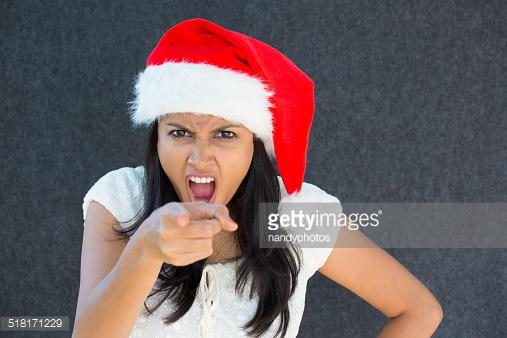

In [ ]:
emotion = 'Angry'
race = 'Indian'
image_file_name = 'mad_woman_95.jpg'
image_full_path = Path(RACEDS_PATH,emotion,race,image_file_name)
print(image_full_path)
img = Image.open(image_full_path).convert("RGB")
img

In [ ]:
# self.mtcnn = MTCNN(image_size=224, device= self.device)
img_cropped = mtcnn(img)
img_cropped

In [ ]:
print(torch.min(img_cropped), torch.max(img_cropped))
image_cropped_rescaled = (img_cropped + 1) / 2
print(torch.min(image_cropped_rescaled), torch.max(image_cropped_rescaled))
image_cropped_rescaled.shape

In [ ]:
def show_image(image_tensor):
  image_tensor_np = image_tensor.numpy()
  # print("before", image_tensor_np.shape)
  image_tensor_np = image_tensor_np.squeeze()
  # print("post squeeze", image_tensor_np.shape)

  # Since Matplotlib expects images in (H, W, C) format, transpose the tensor from (C, H, W)
  image_tensor_np = np.transpose(image_tensor_np, (1, 2, 0))
  # print("after", image_tensor_np.shape)

  # Display the image using Matplotlib
  plt.imshow(image_tensor_np)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  # img

In [ ]:
# Convert the tensor to a numpy array
image_cropped_np = image_cropped_rescaled.numpy()

# Since Matplotlib expects images in (H, W, C) format, transpose the tensor from (C, H, W)
image_cropped_np = np.transpose(image_cropped_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_cropped_np)
plt.axis('off')  # Turn off axis labels
plt.show()
img

In [ ]:
#OK

# Define the labels map
labels_map = {
    "0": "angry",
    "1": "disgust",
    "2": "fear",
    "3": "happy",
    "4": "sad",
    "5": "surprise",
    "6": "neutral"
}

cpu_batch_size = 6

# List of labels
labels = list(labels_map.values())

# Create the one-hot encoding matrix
label_matrix = torch.eye(len(labels))

# Function to get the one-hot vector for a specific emotion
def get_one_hot_vector(emotion, labels = labels, label_matrix= label_matrix):
    if emotion in labels:
        idx = labels.index(emotion)
        return label_matrix[idx]
    else:
        raise ValueError(f"Emotion '{emotion}' not found in labels.")

In [ ]:
# for _,emotion in labels_map.items():
#   print(get_one_hot_vector(emotion))

In [ ]:
# label_matrix[1,:]== label_matrix[1]
# print(label_matrix[1,:],label_matrix[1])

## Load Images from list

In [ ]:
# GDRIVE_DEMO_FOLDER = '/content/gdrive/MyDrive/da_demo'
# DEMO_PATH = Path(GDRIVE_DEMO_FOLDER,'fer')
# dir_suffix = '27_07' # str(time.strftime("%d_%m"))
# DEMO_STORAGE_PATH = Path(DEMO_PATH, dir_suffix)
# list_samples_file_name = 'list_samples.pt'
# list_samples_file_path = Path(DEMO_STORAGE_PATH,list_samples_file_name)
# list_samples_loaded = torch.load(list_samples_file_path)
# list_samples_loaded[0]

In [ ]:
### Dataset without datafolder path, uses tensor in dataframe #OK

class CustomImageDataset(Dataset):
    def __init__(self, dataframe,
                 transform=None,
                 image_file_colname = 'image',
                 race_colname  = 'gt_race',
                 gt_emotion_colname  = 'gt_emotion',
                 image_pil_colname = 'image_pil'):
        self.dataframe = dataframe.reset_index(drop=True)
        self.basic_transform = transforms.Compose([transforms.Resize(224),
                                                   transforms.ToTensor()])
        self.transform = transform
        self.image_file_colname = image_file_colname
        self.race_colname = race_colname
        self.gt_emotion_colname = gt_emotion_colname
        self.image_pil_colname = image_pil_colname

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_filename = self.dataframe.loc[idx, self.image_file_colname]
        race = self.dataframe.loc[idx, self.race_colname]
        emotion = self.dataframe.loc[idx, self.gt_emotion_colname]
        emotion_one_hot = get_one_hot_vector(emotion.lower()) # emotion.lower() to match the labels
        image = self.dataframe.loc[idx, self.image_pil_colname] # pil image
        cropped_image = mtcnn(image) # mtcnn takes in PIL, returns tensor in cropped image 3x224x224

        if self.transform:
          image_transformed = self.transform(image) # original image, this converts PIL into tensor
        else:
          image_transformed = self.basic_transform(image) # original image, this converts PIL into tensor

        if cropped_image is None: #error in cropping
          # in case of error, original image is returned
          return image_transformed, emotion_one_hot, image_transformed, race
        else: # cropping went ok
          # cropped image alongside original image is returned, there is no transform on cropped image.
          cropped_image = (cropped_image + 1) / 2 # changing form -1,1 to 0,1
          return cropped_image, emotion_one_hot, image_transformed, race

In [ ]:

# class CustomImageDataset(Dataset):
#     def __init__(self,
#                  list_samples, # list_samples.append((row['image'],row_image_transformed,row['gt_emotion'],row['gt_race'],row['p_emotion_non_dann'],row['p_emotion_dann'],row['p_emotion_ewc_dann']))
#                  transform=None):
#         self.list_samples = list_samples
#         self.basic_transform = transforms.Compose([transforms.Resize(224),
#                                                    transforms.ToTensor()])
#         self.transform = transform
#     def __len__(self):
#         return len(self.list_samples)

#     def __getitem__(self, idx):


#         img_filename = self.list_samples[idx][0]
#         img = self.self.list_samples[idx][1]
#         emotion =self.self.list_samples[idx][2]
#         race = self.list_samples[idx][3]
#         emotion_one_hot = get_one_hot_vector(emotion.lower()) # emotion.lower() to match the labels
#         transform_to_pil  = transforms.ToPILImage()
#         image = transform_to_pil(img)
#         cropped_image = mtcnn(image) # mtcnn takes in PIL, returns tensor in cropped image 3x224x224

#         if self.transform:
#           image_transformed = self.transform(image) # original image, this converts PIL into tensor
#         else:
#           image_transformed = self.basic_transform(image) # original image, this converts PIL into tensor

#         if cropped_image is None: #error in cropping
#           # in case of error, original image is returned
#           return image_transformed, emotion_one_hot, image_transformed, race
#         else: # cropping went ok
#           # cropped image alongside original image is returned, there is no transform on cropped image.
#           cropped_image = (cropped_image + 1) / 2 # changing form -1,1 to 0,1
#           return cropped_image, emotion_one_hot, image_transformed, race


In [ ]:
### Dataset with datafolder path
# class CustomImageDataset(Dataset):
#     def __init__(self, dataframe,
#                  transform=None,
#                  datafolder_path = RACEDS_PATH,
#                  image_file_colname = 'image',
#                  race_colname  = 'gt_race',
#                  gt_emotion_colname  = 'gt_emotion'):
#         self.dataframe = dataframe.reset_index(drop=True)
#         self.basic_transform = transforms.Compose([transforms.Resize(224),
#                                                    transforms.ToTensor()])
#         self.transform = transform
#         self.image_file_colname = image_file_colname
#         self.race_colname = race_colname
#         self.gt_emotion_colname = gt_emotion_colname

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):

#         img_filename = self.dataframe.loc[idx, self.image_file_colname]
#         race = self.dataframe.loc[idx, self.race_colname]
#         emotion = self.dataframe.loc[idx, self.gt_emotion_colname]
#         emotion_one_hot = get_one_hot_vector(emotion.lower()) # emotion.lower() to match the labels

#         image_full_path = Path(RACEDS_PATH,emotion,race,img_filename)

#         image = Image.open(image_full_path).convert("RGB")
#         cropped_image = mtcnn(image) # mtcnn takes in PIL, returns tensor in cropped image 3x224x224

#         if self.transform:
#           image_transformed = self.transform(image) # original image, this converts PIL into tensor
#         else:
#           image_transformed = self.basic_transform(image) # original image, this converts PIL into tensor

#         if cropped_image is None: #error in cropping
#           # in case of error, original image is returned
#           return image_transformed, emotion_one_hot, image_transformed, race
#         else: # cropping went ok
#           # cropped image alongside original image is returned, there is no transform on cropped image.
#           cropped_image = (cropped_image + 1) / 2 # changing form -1,1 to 0,1
#           return cropped_image, emotion_one_hot, image_transformed, race


## Dataset and Dataloaders for multiple conditions

In [ ]:
#OK
"""### Condition 1: Images that are predicted same in non_dann, dann, dann_ewc, ground truth - 30"""

condition_1 = (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_ewc_dann'])
df_condition_1 = df_samples_loaded[condition_1].reset_index(drop=True)

"""### Condition 2: Images that are nok in non_dann, ok in dann and dann_ewc - 20"""
condition_2 = (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_ewc_dann'])
df_condition_2 = df_samples_loaded[condition_2].reset_index(drop=True)

"""### Condition 3. Images that are nok in non_dann, nok in dann and ok in dann_ewc - 27"""
condition_3 = (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_ewc_dann'])
df_condition_3 = df_samples_loaded[condition_3].reset_index(drop=True)

"""### Condition 4. Images that are nok in non_dann, dann_ewc but ok in dann - 24"""
condition_4 = (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_ewc_dann'])
df_condition_4 = df_samples_loaded[condition_4].reset_index(drop=True)

"""### Condition 5. Images which are non_ok on all 3 - 40"""

condition_5 = (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_ewc_dann'])
df_condition_5 = df_samples_loaded[condition_5].reset_index(drop=True)

"""### Condition 6. Images that are ok in non_dann, but nok in dann and dann_ewc - 30"""
condition_6 = (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_ewc_dann'])
df_condition_6 = df_samples_loaded[condition_6].reset_index(drop=True)

"""### Condition 7: Images that are ok in non_dann, dann, but nok in dann_ewc - 25"""
condition_7 = (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_ewc_dann'])
df_condition_7 = df_samples_loaded[condition_7].reset_index(drop=True)

"""### Condition 8: Images that are ok in non_dann, dann_ewc, but nok in dann"""
condition_8 = (df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_non_dann']) & (df_samples_loaded['gt_emotion'] != df_samples_loaded['p_emotion_dann']) & ( df_samples_loaded['gt_emotion'] == df_samples_loaded['p_emotion_ewc_dann'])
df_condition_8 = df_samples_loaded[condition_8].reset_index(drop=True)


In [ ]:
for condition in [df_condition_1, df_condition_2, df_condition_3, df_condition_4, df_condition_5,df_condition_6,df_condition_7,df_condition_8]:
  print(condition.shape)

(30, 8)
(20, 8)
(27, 8)
(24, 8)
(40, 8)
(30, 8)
(25, 8)
(25, 8)


In [ ]:
#OK
"""## Dataset and Dataloader for Conditions 1 to 8"""

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# condition 1
dataset_condition_1 = CustomImageDataset(dataframe= df_condition_1, transform=transform)
dataloader_condition_1 = DataLoader(dataset_condition_1, batch_size=cpu_batch_size, shuffle=True)
# condition 2
dataset_condition_2 = CustomImageDataset(dataframe= df_condition_2, transform=transform)
dataloader_condition_2 = DataLoader(dataset_condition_2, batch_size=cpu_batch_size, shuffle=True)
# condition 3
dataset_condition_3 = CustomImageDataset(dataframe= df_condition_3, transform=transform)
dataloader_condition_3 = DataLoader(dataset_condition_3, batch_size=cpu_batch_size, shuffle=True)
# condition 4
dataset_condition_4 = CustomImageDataset(dataframe= df_condition_4, transform=transform)
dataloader_condition_4 = DataLoader(dataset_condition_4, batch_size=cpu_batch_size, shuffle=True)
# condition 5
dataset_condition_5 = CustomImageDataset(dataframe= df_condition_5, transform=transform)
dataloader_condition_5 = DataLoader(dataset_condition_5, batch_size=cpu_batch_size, shuffle=True)
# condition 6
dataset_condition_6 = CustomImageDataset(dataframe= df_condition_6, transform=transform)
dataloader_condition_6 = DataLoader(dataset_condition_6, batch_size=cpu_batch_size, shuffle=True)
# condition 7
dataset_condition_7 = CustomImageDataset(dataframe= df_condition_7, transform=transform)
dataloader_condition_7 = DataLoader(dataset_condition_7, batch_size=cpu_batch_size, shuffle=True)
# condition 8
dataset_condition_8 = CustomImageDataset(dataframe= df_condition_8, transform=transform)
dataloader_condition_8 = DataLoader(dataset_condition_8, batch_size=cpu_batch_size, shuffle=True)

### Dataset and Dataloader Condition 1

In [ ]:
# # Define  transformations you want to apply to the images
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224
#     transforms.ToTensor(),          # Convert images to PyTorch tensors
# ])

# # Create an instance of your custom dataset
# # dataset = CustomImageDataset(dataframe=filtered_df_condition_1, transform=transform)
# dataset = CustomImageDataset(dataframe=sampled_df_condition_1, transform=transform)


# # Create a DataLoader
# dataloader = DataLoader(dataset, batch_size=cpu_batch_size, shuffle=True)


### Dataset and Dataloader Condition 2




In [ ]:
# dataset_condition_2 = CustomImageDataset(dataframe=sampled_df_condition_2, transform=transform)
# dataloader_condition_2 = DataLoader(dataset_condition_2, batch_size=cpu_batch_size, shuffle=True)

### Dataset and Dataloader Condition 3


In [ ]:
# dataset_condition_3 = CustomImageDataset(dataframe=sampled_df_condition_3, transform=transform)
# dataloader_condition_3 = DataLoader(dataset_condition_3, batch_size=cpu_batch_size, shuffle=True)

### Dataset and Dataloader Condition 4


In [ ]:
# dataset_condition_4 = CustomImageDataset(dataframe=sampled_df_condition_4, transform=transform)
# dataloader_condition_4 = DataLoader(dataset_condition_4, batch_size=cpu_batch_size, shuffle=True)

### Dataset and Dataloader Condition 5

In [ ]:
# dataset_condition_5 = CustomImageDataset(dataframe=sampled_df_condition_5, transform=transform)
# dataloader_condition_5 = DataLoader(dataset_condition_5, batch_size=cpu_batch_size, shuffle=True)

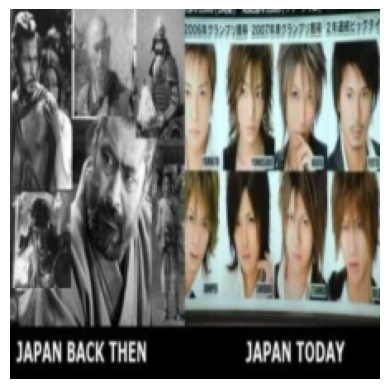

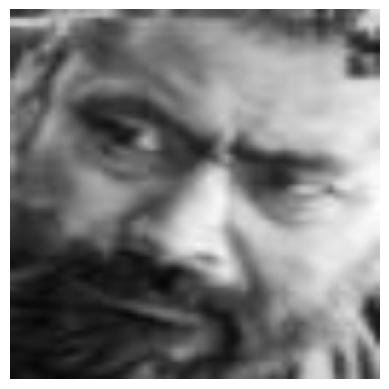

tensor([0., 0., 0., 0., 0., 0., 1.]) neutral
Asian


In [ ]:
# Example of iterating through the DataLoader
for batch in dataloader_condition_6:
    cropped_images, emotions, images, races = batch
    cropped_image, emotion, image, race = cropped_images[0], emotions[0], images[0], races[0]
    show_image (image)
    show_image(cropped_image)
    print(emotion , labels_map[str(emotion.argmax().item())])
    print(race)
    break

## Network

### Pre-trained network

In [ ]:
#OK
class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [ ]:
#OK
model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [ ]:
#OK
class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG, self).__init__()
        #---------------------Feature Extractor Network---------------#

        list_feature_extractor = list(model_pretrained.children())[:-4]
        self.feature_extractor = nn.Sequential(*list_feature_extractor)

        #---------------------Class Classifier------------------------#

        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        self.class_classifier = nn.Sequential(*list_class_classifer)

        #---------------------Domain Classifier-----------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [ ]:
# model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7)
# model = model.to(device=device)

## Downloading Models

In [ ]:
#OK
GDRIVE_FOLDER = '/content/gdrive/MyDrive/CV_FER'
MODEL_DIR = Path(GDRIVE_FOLDER,"models") # for drive
non_dann_model_name = 'non_dann_sfew_expw_23_05_wo_se_a.pt'
dann_model_name = 'dann_sfew_expw_23_05_wo_se_a.pt'
ewc_dann_model_name = 'ewc_dann_sfew_expw_23_05_wo_se_a.pt'

In [ ]:
#OK
skeleton_model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy

### Non-DANN Model

In [ ]:
#OK
NON_DANN_MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_sfew_expw', non_dann_model_name))
print(NON_DANN_MODEL_PATH)
non_dann_model_sfew_expw_inference =  deepcopy(skeleton_model) # DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy
non_dann_model_sfew_expw_inference.load_state_dict(torch.load(NON_DANN_MODEL_PATH,map_location=torch.device(device)))
# non_dann_model_sfew_expw_inference.eval()

/content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw/non_dann_sfew_expw_23_05_wo_se_a.pt


<All keys matched successfully>

### DANN Model

In [ ]:
#OK
DANN_MODEL_PATH = Path(os.path.join(MODEL_DIR, f'dann_sfew_expw', dann_model_name))
print(DANN_MODEL_PATH)
dann_model_sfew_expw_inference =  deepcopy(skeleton_model) # DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy
dann_model_sfew_expw_inference.load_state_dict(torch.load(DANN_MODEL_PATH,map_location=torch.device(device)))
# dann_model_sfew_expw_inference.eval()

/content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_23_05_wo_se_a.pt


<All keys matched successfully>

### EWC DANN Model

In [ ]:
#OK
EWC_MODEL_PATH = Path(os.path.join(MODEL_DIR, f'ewc_dann_sfew_expw', ewc_dann_model_name))
print(EWC_MODEL_PATH)
ewc_dann_model_sfew_expw_inference =  deepcopy(skeleton_model) # DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy
ewc_dann_model_sfew_expw_inference.load_state_dict(torch.load(EWC_MODEL_PATH,map_location=torch.device(device)))
# ewc_dann_model_sfew_expw_inference.to(device)

/content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_23_05_wo_se_a.pt


<All keys matched successfully>

# UI

## Inference

In [ ]:
#OK
transform_to_pil  = transforms.ToPILImage()
emotion_labels = [label.capitalize() for label in list(labels_map.values())]

def get_images(dataloader = dataloader_condition_1):
    cropped_images, emotions, images, races = next(iter(dataloader))

    list_pil_cropped_images = [transform_to_pil(cropped_img) for cropped_img in cropped_images]
    list_pil_images = [transform_to_pil(img) for img in images]
    list_emotions = list(emotions) # list of one hot tensort
    list_emotions = [ emotion_labels[torch.argmax(emotion).item()] for emotion in emotions]

    # return list_pil_cropped_images, list(emotions), list_pil_images, list(races)
    return list_pil_cropped_images, list_emotions, list_pil_images, list(races)

In [ ]:
#OK
def get_images_condition_2(): return get_images(dataloader_condition_2)
def get_images_condition_3(): return get_images(dataloader_condition_3)
def get_images_condition_4(): return get_images(dataloader_condition_4)
def get_images_condition_5(): return get_images(dataloader_condition_5)
def get_images_condition_6(): return get_images(dataloader_condition_6)
def get_images_condition_7(): return get_images(dataloader_condition_7)
def get_images_condition_8(): return get_images(dataloader_condition_8)

In [ ]:
get_images()

([<PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>],
 ['Angry', 'Neutral', 'Sad', 'Fear', 'Neutral', 'Surprise'],
 [<PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>],
 ['Latino', 'White', 'African', 'Asian', 'Middle Eastern', 'Latino'])

In [ ]:
# list(labels_map.values())
# emotion_labels = [label.capitalize() for label in list(labels_map.values())]
# emotion_labels

### classify_image_all_models

In [ ]:
#OK
emotion_labels = [label.capitalize() for label in list(labels_map.values())]

def classify_image_all_models(input_image):
    # print("-------")
    # print(input_image)
    # print(type(input_image))
    # print("-------")

    image_transforms =  transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor()
                                  ])
    transformed_image = image_transforms(input_image)
    image_tensor = transformed_image.to(device).unsqueeze(0)
    # image_tensor = input_image.to(device).unsqueeze(0)

    list_confidences = []
    for model in [non_dann_model_sfew_expw_inference, dann_model_sfew_expw_inference, ewc_dann_model_sfew_expw_inference]:
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            logits, _ , _ = model((image_tensor*255))
            output = F.softmax(logits.view(-1), dim = -1)

            confidences = [(emotion_labels[i], float(output[i])) for i in range(len(emotion_labels))]
            confidences.sort(key=lambda x: x[1], reverse=True)
            confidences = OrderedDict(confidences[:2])
            label = torch.argmax(output).item()
            list_confidences.append(confidences)

    return list_confidences[0], list_confidences[1], list_confidences[2]

In [ ]:
# def get_correct_predictions(prediction, labels):
#     """
#     Function to return total number of correct predictions
#     :param prediction: Model predictions on a given sample of data
#     :param labels: Correct labels of a given sample of data
#     :return: Number of correct predictions
#     """
#     return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item() #.argmax(dim=1)

# def test_model_race(model,
#                     device,
#                     test_loader,
#                     result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
#     model = model.to(device)
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0

#    # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(test_loader):
#         # for batch_idx, (data, target, name, race) in enumerate(test_loader): #     cropped_images, emotions, images, races = batch
#             data_plural, targets, images, races = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)

#             # # Put the images and labels on the selected device
#             # data, target = data.to(device), target.to(device)

#             # Pass the images to the output and get the model predictions
#             class_outputs, _ , _ = model((data_plural*255))
#             # Sum up batch correct predictions
#             correct += get_correct_predictions(class_outputs, targets)


#     return correct, test_loss, accuracy, result


In [ ]:
#OK
def display_image():
    # Load the image from a local file
    image = Image.open("/content/DBMF.png")
    return image

cases_table = """
| **Cases (Tabs)** | **Baseline / Non DANN** | **DANN without EWC** | **DANN with EWC** |
|--------------|--------------|--------------|--------------|
| **Case 1 (C1)**    | **Same** as GT    | **Same** as GT     | **Same** as GT |
| **Case 2 (C2)**    | **Different** from GT        | **Same** as GT | **Same** as GT |
| **Case 3 (C3)**    | **Different** from GT        | **Different** from GT       | **Same** as GT|
| **Case 4 (C4)**    | **Different** from GT        | **Same** as GT | **Different** from GT   |
| **Case 5 (C5)**    | **Different** from GT        | **Different** from GT  | **Different** from GT   |
| **Case 6 (C6)**    | **Same** as GT       | **Different** from GT  | **Different** from GT   |
| **Case 7 (C7)**    | **Same** as GT       | **Same** as GT | **Different** from GT   |
| **Case 8 (C8)**    | **Same** as GT        | **Different** from GT  | **Same** as GT  |
"""

# App - without buttons

In [ ]:
#OK
"""Gradio UI"""
theme = gr.themes.Base()

with gr.Blocks(theme=theme) as demo:
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Practical Implementation of Demographic Bias Mitigation Framework")
        with gr.Row():
            with gr.Column():
                image_output = gr.Image(value=display_image(), label = "Demographic Bias Mitigation Framework",height = 400, width = 600, show_label = True)
            with gr.Column():
                gr.Markdown('''
                    Source - Static Facial Expression in Wild (SFEW) 2.0 or SFEW2.0
                    -------
                    - SFEW 2.0 dataset is split into training (958 samples), validation (436 samples), and test sets (372 samples).
                    - Each image is labelled with one of seven emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.
                    - It is used as racially bias source domain dataset in this demonstration
                    ''')
                gr.Markdown(
                    ''' Target - Expression in-the-Wild or ExpW dataset
                    -------
                    - It comprises of 91,793 manually labeled images without specific Train/Validation/Test splits.
                    - Similar to SFEW 2.0, each image in the ExpW dataset is categorized as: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.
                    - It is used as racially unbiased target domain dataset in this demonstration
                    '''
                )
                gr.Markdown(
                    '''
                    Evaluation Dataset - ExpW (Race annotated)
                    -------
                    - A subset of 8,458 images from the ExpW dataset was randomly selected and annotated with race in addition to the existing emotion labels.
                    - This subset also served as the validation dataset - **The images from this validation set are used**
                    '''
                )

        with gr.Row():
            with gr.Column():
                with gr.Row():
                    gr.Markdown(''' **Fig. 1.** **DANN based demographic bias mitigation framework (DBMF)**: Framework supports
                    (a) Non-domain adapted (Baseline, Non-DA) training, (b) Domain adapted (DA) training and (c) bias and task accuracy evaluation steps.
                    Pre-processed data is fed into feature extractor. Fully connected network in Task-specific component has classification/regression heads.
                    Domain classifier comprises of fully connected layers with a binary classification head.
                    Unsupervised DA is supported by a gradient reversal layer, which flips errors during backpropagation, forcing the feature extractor
                    to prioritize domain-invariant features that remain task-specific.
                    For (c) bias and task accuracy evaluation, an evaluation test set is used to understand task accuracy and bias using statistical metrics / tests.
                    ''')
            with gr.Column():
                with gr.Row():
                    gr.Markdown(''' **Table. 1.** Cases (Tabs) showing  predicted emotion in 3 networks as compared to ground truth emotion''')
                with gr.Row():
                    gr.HTML("<b><span style='color: blue;'>Click on the tabs for corresponding cases</span></b>")
                with gr.Row():
                    gr.Markdown(cases_table)
                with gr.Row():
                    gr.HTML("<b><span style='color: blue;'>Click on the tab - Predict Emotion for your own image - to predict emotions for your image(s) </span></b>")
    ################################################
    with gr.Tab("C1: All Same") as tabs1:
        imgs = gr.State()

        with gr.Row():
            with gr.Column():
                gr.Markdown(''' In this case (scenario), we see that the predictions of all the models is same.

                The consistency in predictions across all models can be attributed to the robustness of the image features, the clarity and distinctness of the emotions, the effective representation of similar examples in the training data, and the overall quality of the images.

                In case of multiple faces in image, the correct face is cropped for which the emotion label is available.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")

            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 1 (C1): All Same**    | **Same** as emotion GT    | **Same** as emotion GT     | **Same** as emotion GT |

                """
                )


        with gr.Row():
            with gr.Column(scale=1):
                gallery = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C1 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    # selected = gr.Number(show_label=False)
                    selected = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images, list_emotions, big_images, list_races = get_images()

        def get_big_images():
            return big_images, big_images

        def get_select_index(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions[evt.index], gr.update(visible=True), cropped_images[evt.index], list_races[evt.index], gr.update(visible=True)

        refresh_case1 = gr.Checkbox(visible=False)

        def refresh_gallery():
            return get_big_images()

        refresh_case1.change(refresh_gallery, None, [gallery, imgs])
        gallery.select(get_select_index, None, [selected, selected, cropped_image_display, txtbox_race, txtbox_race])
        button_classify_C1.click(fn=classify_image_all_models, inputs=[cropped_image_display],
                                 outputs=[label_classify_non_dann, label_classify_dann, label_classify_ewc])

    ################################################
    with gr.Tab("C2:Same:DANN, EWC DANN | Diff:Base") as tabs2:
        imgs_2 = gr.State()

        with gr.Row():
            with gr.Column():
                gr.Markdown(''' In this case (scenario), we see that emotion predicted same as GT by DANN with and without EWC, but different by Baseline (Non-DANN)

                The key factors contributing to the correct predictions by the DANN models (with and without EWC) and the incorrect predictions by the Baseline (Non-DANN) model include the effectiveness of domain adaptation, feature sensitivity to race, robustness to biases, improved generalization capabilities, and the overall ability to handle domain shifts.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")
            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 2 (C2): Emotion predicted same as GT by DANN with and without EWC, but different by Baseline (Non-DANN)**    | **Different** from emotion GT        | **Same** as emotion GT | **Same** as emotion GT |

                """
                )

        with gr.Row():
            with gr.Column(scale=1):
                gallery_2 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_2 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C2 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_2 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_2 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_2 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_2 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_2 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_2, list_emotions_2, big_images_2, list_races_2 = get_images_condition_2()

        def get_big_images_2():
            return big_images_2, big_images_2

        def get_select_index_2(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_2[evt.index], gr.update(visible=True), cropped_images_2[evt.index], list_races_2[evt.index], gr.update(visible=True)

        refresh_case2 = gr.Checkbox(visible=False)

        def refresh_gallery_2():
            return get_big_images_2()

        refresh_case2.change(refresh_gallery_2, None, [gallery_2, imgs_2])
        gallery_2.select(get_select_index_2, None, [selected_2, selected_2, cropped_image_display_2, txtbox_race_2, txtbox_race_2])
        button_classify_C2.click(fn=classify_image_all_models, inputs=[cropped_image_display_2],
                                 outputs=[label_classify_non_dann_2, label_classify_dann_2, label_classify_ewc_2])

    ################################################
    with gr.Tab("C3:Same:EWC DANN | Diff:Base, DANN")as tabs3:
        imgs_3 = gr.State()
        with gr.Row():
            with gr.Column():
                gr.Markdown(''' In this case (scenario), we see that emotion predicted same as GT by DANN with EWC, but different by Baseline (Non-DANN) and DANN without EWC.

                This can be attributed to the complexity (with respect to assigning emotion) in the images themselves, image quality, incorrect face crop and busy images.

                Another plausible attribution is that The DANN model with EWC might have learned features that are more invariant to irrelevant variations (such as race or other biases) and more sensitive to the actual emotional content of the images.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")
            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 3 (C3): Emotion predicted same as GT by DANN with EWC, but differently by Baseline( Non-DANN) and DANN without EWC**    | **Different** from emotion GT        | **Different** from emotion GT       | **Same** as emotion GT|
                """
                )

        with gr.Row():
            with gr.Column(scale=1):
                gallery_3 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_3 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C3 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_3 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_3 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_3 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_3 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_3 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_3, list_emotions_3, big_images_3, list_races_3 = get_images_condition_3()

        def get_big_images_3():
            return big_images_3, big_images_3

        def get_select_index_3(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_3[evt.index], gr.update(visible=True), cropped_images_3[evt.index], list_races_3[evt.index], gr.update(visible=True)

        refresh_case3 = gr.Checkbox(visible=False)

        def refresh_gallery_3():
            return get_big_images_3()

        refresh_case3.change(refresh_gallery_3, None, [gallery_3, imgs_3])
        gallery_3.select(get_select_index_3, None, [selected_3, selected_3, cropped_image_display_3, txtbox_race_3, txtbox_race_3])
        button_classify_C3.click(fn=classify_image_all_models, inputs=[cropped_image_display_3],
                                 outputs=[label_classify_non_dann_3, label_classify_dann_3, label_classify_ewc_3])

    ################################################
    with gr.Tab("C4:Same:DANN | Diff:Base, EWC DANN") as tabs4:
        imgs_4 = gr.State()
        with gr.Row():
            with gr.Column():
                gr.Markdown(''' In this case (scenario), we see that emotion predicted same as GT by DANN without EWC, but different by Baseline (Non-DANN) and DANN with EWC.

                This can be attributed to the over-regularization by EWC failing adaptation and generalization. The DANN model without EWC might have found a balance between generalization and specificity that was optimal for this particular case.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")

            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 4 (C4): Emotion predicted same as GT by DANN without EWC, but differently by Baseline( Non-DANN) and DANN with EWC **    | **Different** from emotion GT | **Same** as emotion GT  | **Different** from emotion GT    |
                """
                )


        with gr.Row():
            with gr.Column(scale=1):
                gallery_4 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_4 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C4 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_4 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_4 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_4 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_4 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_4 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_4, list_emotions_4, big_images_4, list_races_4 = get_images_condition_4()

        def get_big_images_4():
            return big_images_4, big_images_4

        def get_select_index_4(evt: gr.SelectData):
            return list_emotions_4[evt.index], gr.update(visible=True), cropped_images_4[evt.index], list_races_4[evt.index], gr.update(visible=True)

        refresh_case4 = gr.Checkbox(visible=False)

        def refresh_gallery_4():
            return get_big_images_4()

        refresh_case4.change(refresh_gallery_4, None, [gallery_4, imgs_4])
        gallery_4.select(get_select_index_4, None, [selected_4, selected_4, cropped_image_display_4, txtbox_race_4, txtbox_race_4])
        button_classify_C4.click(fn=classify_image_all_models, inputs=[cropped_image_display_4],
                                 outputs=[label_classify_non_dann_4, label_classify_dann_4, label_classify_ewc_4])

    ################################################
    with gr.Tab("C5: All Diff") as tabs5:
        imgs_5 = gr.State()

        with gr.Row():
            with gr.Column():
                gr.Markdown(''' In this case (scenario), we see that emotion predicted are different from GT by all the models.

                The consistent failure of all models to correctly predict the emotions as per the ground truth could be can be attributed to ambiguous or noisy data, inherent model limitation, adaptation failure (significant domain shift), complex emotion expressions, features extracted by the models might not be sensitive or relevant enough to the specific emotional cues present in these images.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")
            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 5 (C5) : Emotion predicted are different from GT by all the models**    | **Different** from emotion GT      | **Different** from emotion GT | **Different** from emotion GT |
                """
                )



        with gr.Row():
            with gr.Column(scale=1):
                gallery_5 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_5 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C5 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_5 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_5 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_5 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_5 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_5 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_5, list_emotions_5, big_images_5, list_races_5 = get_images_condition_5()

        def get_big_images_5():
            return big_images_5, big_images_5

        def get_select_index_5(evt: gr.SelectData):
            return list_emotions_5[evt.index], gr.update(visible=True), cropped_images_5[evt.index], list_races_5[evt.index], gr.update(visible=True)

        refresh_case5 = gr.Checkbox(visible=False)

        def refresh_gallery_5():
            return get_big_images_5()

        refresh_case5.change(refresh_gallery_5, None, [gallery_5, imgs_5])
        gallery_5.select(get_select_index_5, None, [selected_5, selected_5, cropped_image_display_5, txtbox_race_5, txtbox_race_5])
        button_classify_C5.click(fn=classify_image_all_models, inputs=[cropped_image_display_5],
                                 outputs=[label_classify_non_dann_5, label_classify_dann_5, label_classify_ewc_5])


    ################################################
    with gr.Tab("C6:Same:Base | Diff:DANN, EWC DANN") as tabs6:
        imgs_6 = gr.State()

        with gr.Row():
            with gr.Column():
                gr.Markdown(''' In this case (scenario), we see that emotion predicted same as GT by by Baseline( Non-DANN), but differently  DANN with and without EWC models

                This can be attributed to DANN models overcompensating for the domain shift, leading to misalignment of critical features.

                Another plausible attirbution may be that Baseline (Non-DANN) model may have retained generalizable features relevant for emotion recognition.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")
            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 6 (C6): Emotion predicted same as GT by by Baseline( Non-DANN), but differently  DANN with and without EWC models**    | **Same** as emotion GT   | **Different** from emotion GT | **Different** from emotion GT |                """
                )



        with gr.Row():
            with gr.Column(scale=1):
                gallery_6 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_6 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C6 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_6 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_6 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_6 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_6 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_6 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_6, list_emotions_6, big_images_6, list_races_6 = get_images_condition_6()

        def get_big_images_6():
            return big_images_6, big_images_6

        def get_select_index_6(evt: gr.SelectData):
            return list_emotions_6[evt.index], gr.update(visible=True), cropped_images_6[evt.index], list_races_6[evt.index], gr.update(visible=True)

        refresh_case6 = gr.Checkbox(visible=False)

        def refresh_gallery_6():
            return get_big_images_6()

        refresh_case6.change(refresh_gallery_6, None, [gallery_6, imgs_6])
        gallery_6.select(get_select_index_6, None, [selected_6, selected_6, cropped_image_display_6, txtbox_race_6, txtbox_race_6])
        button_classify_C6.click(fn=classify_image_all_models, inputs=[cropped_image_display_6],
                                 outputs=[label_classify_non_dann_6, label_classify_dann_6, label_classify_ewc_6])
    ################################################
    with gr.Tab("C7:Same:Base, DANN | Diff: EWC DANN") as tabs7:
        imgs_7 = gr.State()

        with gr.Row():
            with gr.Column():
                gr.Markdown(''' In this case (scenario), we see that emotion predicted same as GT by by Baseline( Non-DANN) and DANN without EWC, but differently by DANN with models

                This can be attributed to potential over-regularization of DANN with EWC model, emotion expression complexity, label noise, image quality, incorrect face crop.

                EWC’s constraints might hinder the model’s ability to adapt effectively to the target domain features, leading to incorrect predictions.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")
            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 7 (C7): Emotion predicted same as GT by by Baseline( Non-DANN) and DANN without EWC, but differently by DANN with models**    | **Same** as emotion GT       | **Same** as emotion GT | **Different** from emotion GT   |                """
                )

        with gr.Row():
            with gr.Column(scale=1):
                gallery_7 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_7 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C7 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_7 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_7 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_7 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_7 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_7 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_7, list_emotions_7, big_images_7, list_races_7 = get_images_condition_7()

        def get_big_images_7():
            return big_images_7, big_images_7

        def get_select_index_7(evt: gr.SelectData):
            return list_emotions_7[evt.index], gr.update(visible=True), cropped_images_7[evt.index], list_races_7[evt.index], gr.update(visible=True)

        refresh_case7 = gr.Checkbox(visible=False)

        def refresh_gallery_7():
            return get_big_images_7()

        refresh_case7.change(refresh_gallery_7, None, [gallery_7, imgs_7])
        gallery_7.select(get_select_index_7, None, [selected_7, selected_7, cropped_image_display_7, txtbox_race_7, txtbox_race_7])
        button_classify_C7.click(fn=classify_image_all_models, inputs=[cropped_image_display_7],
                                 outputs=[label_classify_non_dann_7, label_classify_dann_7, label_classify_ewc_7])
    ################################################
    with gr.Tab("C8:Same:Base, EWC DANN | Diff: DANN") as tabs8:
        imgs_8 = gr.State()

        with gr.Row():
            with gr.Column():
                gr.Markdown('''
                In this case (scenario), we see that emotion predicted same as GT by by Baseline( Non-DANN) and DANN with EWC, but differently by DANN without models.

                This can be attributed to the lack of feature preservation in the DANN model without EWC, which could lead to over-adaptation or loss of crucial features.
                ''')
                gr.HTML("<b><span style='color: blue;'>Select the image from the gallery, <br>Click the Button to predict emotions using 3 models</span></b>")
            with gr.Column():
                gr.Markdown(
                """
                | **Demonstration scenario** | **Prediction Emotion for Baseline (Non-DANN)** | **Prediction Emotion for DANN without EWC** | **Prediction Emotion for DANN with EWC** |
                |--------------|--------------|--------------|--------------|
                | **Case 8 (C8): Emotion predicted same as GT by by Baseline( Non-DANN) and DANN with EWC, but differently by DANN without models**    | **Same** as emotion GT        | **Different** from emotion GT  | **Same** as emotion GT  |
                """
                )

        with gr.Row():
            with gr.Column(scale=1):
                gallery_8 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_8 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C8 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_8 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_8 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_8 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_8 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_8 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_8, list_emotions_8, big_images_8, list_races_8 = get_images_condition_8()

        def get_big_images_8():
            return big_images_8, big_images_8

        def get_select_index_8(evt: gr.SelectData):
            return list_emotions_8[evt.index], gr.update(visible=True), cropped_images_8[evt.index], list_races_8[evt.index], gr.update(visible=True)

        refresh_case8 = gr.Checkbox(visible=False)

        def refresh_gallery_8():
            return get_big_images_8()

        refresh_case8.change(refresh_gallery_8, None, [gallery_8, imgs_8])
        gallery_8.select(get_select_index_8, None, [selected_8, selected_8, cropped_image_display_8, txtbox_race_8, txtbox_race_8])
        button_classify_C8.click(fn=classify_image_all_models, inputs=[cropped_image_display_8],
                                 outputs=[label_classify_non_dann_8, label_classify_dann_8, label_classify_ewc_8])

    ################################################
    with gr.Tab("Predict Emotion for your own Image") as tabs9:

        with gr.Row():
            gr.HTML("<b><span style='color: red;'>Upload an image and predict emotion for the image</span></b>")

        with gr.Row():
            with gr.Column(scale=1):
                with gr.Row():
                    big_image = gr.Image(label="Upload your own Image", type="pil", height=224, width=224)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_9 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C9 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_9 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_9 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_9 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)


        def crop_image(big_image):
            cropped_image = mtcnn(big_image) # mtcnn takes in PIL, returns tensor in cropped image 3x224x224

            if cropped_image is None: #error in cropping
            # in case of error, original image is returned
                return big_image
            else: # cropping went ok
            # cropped image is returned, there is no transform on cropped image.
                cropped_image = (cropped_image + 1) / 2 # changing form -1,1 to 0,1
                transform_to_pil  = transforms.ToPILImage() #output image has to be returned in PIL format
                return transform_to_pil(cropped_image)


        big_image.change(fn=crop_image, inputs=[big_image], outputs=[cropped_image_display_9])
        button_classify_C9.click(fn=classify_image_all_models, inputs=[cropped_image_display_9],
                                 outputs=[label_classify_non_dann_9, label_classify_dann_9, label_classify_ewc_9])
    ################################################

    def refresh_tab(): return True

    tabs1.select(lambda x: True, None, [refresh_case1])
    tabs2.select(refresh_tab, None, [refresh_case2])
    tabs3.select(refresh_tab, None, [refresh_case3])
    tabs4.select(refresh_tab, None, [refresh_case4])
    tabs5.select(refresh_tab, None, [refresh_case5])
    tabs6.select(refresh_tab, None, [refresh_case6])
    tabs7.select(refresh_tab, None, [refresh_case7])
    tabs8.select(refresh_tab, None, [refresh_case8])

demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/utils.py:986: UserWarning: Expected 1 arguments for function <function <lambda> at 0x7ed6db0eb640>, received 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:990: UserWarning: Expected at least 1 arguments for function <function <lambda> at 0x7ed6db0eb640>, received 0.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://cbc7d33fffe605f2d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Existing APP - Working with buttons

In [ ]:
"""Gradio UI"""
theme = gr.themes.Base()

with gr.Blocks(theme=theme) as demo:
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Practical Implementation of Demographic Bias Mitigation Framework")
        with gr.Row():
            with gr.Column():
                image_output = gr.Image(value=display_image(), label = "Demographic Bias Mitigation Framework",height = 400, width = 600, show_label = True)
            with gr.Column():
                gr.Markdown('''
                    Source - Static Facial Expression in Wild (SFEW) 2.0 or SFEW2.0
                    -------
                    - SFEW 2.0 dataset is split into training (958 samples), validation (436 samples), and test sets (372 samples).
                    - Each image is labelled with one of seven emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.
                    - It is used as racially bias source domain dataset in this demonstration
                    ''')
                gr.Markdown(
                    ''' Target - Expression in-the-Wild or ExpW dataset
                    -------
                    - It comprises of 91,793 manually labeled images without specific Train/Validation/Test splits.
                    - Similar to SFEW 2.0, each image in the ExpW dataset is categorized as: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.
                    - It is used as racially unbiased target domain dataset in this demonstration
                    '''
                )
                gr.Markdown(
                    '''
                    Evaluation Dataset - ExpW (Race annotated)
                    -------
                    - A subset of 8,458 images from the ExpW dataset was randomly selected and annotated with race in addition to the existing emotion labels.
                    - This subset also served as the validation dataset - **The images from this validation set are used**
                    '''
                )

        with gr.Row():
            with gr.Column():
                gr.Markdown(''' **Fig. 1.** **DANN based demographic bias mitigation framework (DBMF)**: Framework supports
                (a) Non-domain adapted (Baseline, Non-DA) training, (b) Domain adapted (DA) training and (c) bias and task accuracy evaluation steps.
                Pre-processed data is fed into feature extractor. Fully connected network in Task-specific component has classification/regression heads.
                Domain classifier comprises of fully connected layers with a binary classification head.
                Unsupervised DA is supported by a gradient reversal layer, which flips errors during backpropagation, forcing the feature extractor
                to prioritize domain-invariant features that remain task-specific.
                For (c) bias and task accuracy evaluation, an evaluation test set is used to understand task accuracy and bias using statistical metrics / tests.
                ''')
            with gr.Column():
                with gr.Row():
                     gr.Markdown(''' **Table. 1.** Cases showing  predicted emotion in 3 networks as compared to ground truth emotion''')
                with gr.Row():
                    gr.Markdown(cases_table)
    ################################################
    with gr.Tab("C1: All Same") as tabs1:
        imgs = gr.State()

        # gallery = gr.Gallery(allow_preview=False)
        with gr.Row():
            with gr.Column(scale=1):
                gallery = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C1 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    # selected = gr.Number(show_label=False)
                    selected = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images, list_emotions, big_images, list_races = get_images()

        def get_big_images():
            return big_images, big_images

        def get_select_index(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions[evt.index], gr.update(visible=True), cropped_images[evt.index], list_races[evt.index], gr.update(visible=True)

        refresh_case1 = gr.Checkbox(visible=False)

        def refresh_gallery():
            return get_big_images()

        refresh_case1.change(refresh_gallery, None, [gallery, imgs])
        gallery.select(get_select_index, None, [selected, selected, cropped_image_display, txtbox_race, txtbox_race])
        button_classify_C1.click(fn=classify_image_all_models, inputs=[cropped_image_display],
                                 outputs=[label_classify_non_dann, label_classify_dann, label_classify_ewc])

    ################################################
    with gr.Tab("C2:Same:DANN, EWC DANN | Diff:Base") as tabs2:
        imgs_2 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_2 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_2 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C2 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_2 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_2 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_2 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_2 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_2 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_2, list_emotions_2, big_images_2, list_races_2 = get_images_condition_2()

        def get_big_images_2():
            return big_images_2, big_images_2

        def get_select_index_2(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_2[evt.index], gr.update(visible=True), cropped_images_2[evt.index], list_races_2[evt.index], gr.update(visible=True)

        refresh_case2 = gr.Checkbox(visible=False)

        def refresh_gallery_2():
            return get_big_images_2()

        refresh_case2.change(refresh_gallery_2, None, [gallery_2, imgs_2])
        gallery_2.select(get_select_index_2, None, [selected_2, selected_2, cropped_image_display_2, txtbox_race_2, txtbox_race_2])
        button_classify_C2.click(fn=classify_image_all_models, inputs=[cropped_image_display_2],
                                 outputs=[label_classify_non_dann_2, label_classify_dann_2, label_classify_ewc_2])

    ################################################
    with gr.Tab("C3:Same:EWC DANN | Diff:Base, DANN")as tabs3:
        imgs_3 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_3 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_3 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C3 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_3 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_3 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_3 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_3 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_3 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_3, list_emotions_3, big_images_3, list_races_3 = get_images_condition_3()

        def get_big_images_3():
            return big_images_3, big_images_3

        def get_select_index_3(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_3[evt.index], gr.update(visible=True), cropped_images_3[evt.index], list_races_3[evt.index], gr.update(visible=True)

        refresh_case3 = gr.Checkbox(visible=False)

        def refresh_gallery_3():
            return get_big_images_3()

        refresh_case3.change(refresh_gallery_3, None, [gallery_3, imgs_3])
        gallery_3.select(get_select_index_3, None, [selected_3, selected_3, cropped_image_display_3, txtbox_race_3, txtbox_race_3])
        button_classify_C3.click(fn=classify_image_all_models, inputs=[cropped_image_display_3],
                                 outputs=[label_classify_non_dann_3, label_classify_dann_3, label_classify_ewc_3])

    ################################################
    with gr.Tab("C4:Same:DANN | Diff:Base, EWC DANN") as tabs4:
        imgs_4 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_4 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_4 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C4 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_4 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_4 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_4 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_4 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_4 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_4, list_emotions_4, big_images_4, list_races_4 = get_images_condition_4()

        def get_big_images_4():
            return big_images_4, big_images_4

        def get_select_index_4(evt: gr.SelectData):
            return list_emotions_4[evt.index], gr.update(visible=True), cropped_images_4[evt.index], list_races_4[evt.index], gr.update(visible=True)

        refresh_case4 = gr.Checkbox(visible=False)

        def refresh_gallery_4():
            return get_big_images_4()

        refresh_case4.change(refresh_gallery_4, None, [gallery_4, imgs_4])
        gallery_4.select(get_select_index_4, None, [selected_4, selected_4, cropped_image_display_4, txtbox_race_4, txtbox_race_4])
        button_classify_C4.click(fn=classify_image_all_models, inputs=[cropped_image_display_4],
                                 outputs=[label_classify_non_dann_4, label_classify_dann_4, label_classify_ewc_4])

    ################################################
    with gr.Tab("C5: All Diff") as tabs5:
        imgs_5 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_5 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_5 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C5 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_5 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_5 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_5 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_5 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_5 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_5, list_emotions_5, big_images_5, list_races_5 = get_images_condition_5()

        def get_big_images_5():
            return big_images_5, big_images_5

        def get_select_index_5(evt: gr.SelectData):
            return list_emotions_5[evt.index], gr.update(visible=True), cropped_images_5[evt.index], list_races_5[evt.index], gr.update(visible=True)

        refresh_case5 = gr.Checkbox(visible=False)

        def refresh_gallery_5():
            return get_big_images_5()

        refresh_case5.change(refresh_gallery_5, None, [gallery_5, imgs_5])
        gallery_5.select(get_select_index_5, None, [selected_5, selected_5, cropped_image_display_5, txtbox_race_5, txtbox_race_5])
        button_classify_C5.click(fn=classify_image_all_models, inputs=[cropped_image_display_5],
                                 outputs=[label_classify_non_dann_5, label_classify_dann_5, label_classify_ewc_5])


    ################################################
    with gr.Tab("C6:Same:Base | Diff:DANN, EWC DANN") as tabs6:
        imgs_6 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_6 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_6 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C6 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_6 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_6 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_6 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_6 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_6 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_6, list_emotions_6, big_images_6, list_races_6 = get_images_condition_6()

        def get_big_images_6():
            return big_images_6, big_images_6

        def get_select_index_6(evt: gr.SelectData):
            return list_emotions_6[evt.index], gr.update(visible=True), cropped_images_6[evt.index], list_races_6[evt.index], gr.update(visible=True)

        refresh_case6 = gr.Checkbox(visible=False)

        def refresh_gallery_6():
            return get_big_images_6()

        refresh_case6.change(refresh_gallery_6, None, [gallery_6, imgs_6])
        gallery_6.select(get_select_index_6, None, [selected_6, selected_6, cropped_image_display_6, txtbox_race_6, txtbox_race_6])
        button_classify_C6.click(fn=classify_image_all_models, inputs=[cropped_image_display_6],
                                 outputs=[label_classify_non_dann_6, label_classify_dann_6, label_classify_ewc_6])
    ################################################
    with gr.Tab("C7:Same:Base, DANN | Diff: EWC DANN") as tabs7:
        imgs_7 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_7 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_7 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C7 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_7 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_7 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_7 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_7 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_7 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_7, list_emotions_7, big_images_7, list_races_7 = get_images_condition_7()

        def get_big_images_7():
            return big_images_7, big_images_7

        def get_select_index_7(evt: gr.SelectData):
            return list_emotions_7[evt.index], gr.update(visible=True), cropped_images_7[evt.index], list_races_7[evt.index], gr.update(visible=True)

        refresh_case7 = gr.Checkbox(visible=False)

        def refresh_gallery_7():
            return get_big_images_7()

        refresh_case7.change(refresh_gallery_7, None, [gallery_7, imgs_7])
        gallery_7.select(get_select_index_7, None, [selected_7, selected_7, cropped_image_display_7, txtbox_race_7, txtbox_race_7])
        button_classify_C7.click(fn=classify_image_all_models, inputs=[cropped_image_display_7],
                                 outputs=[label_classify_non_dann_7, label_classify_dann_7, label_classify_ewc_7])
    ################################################
    with gr.Tab("C8:Same:Base, EWC DANN | Diff: DANN") as tabs8:
        imgs_8 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_8 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_8 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C8 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_8 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_8 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_8 = gr.Label(label="Baseline(Non DANN) Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_8 = gr.Label(label="DANN Predicted Emotion", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_8 = gr.Label(label="EWC DANN Predicted Emotion", num_top_classes=2, visible=True)

        cropped_images_8, list_emotions_8, big_images_8, list_races_8 = get_images_condition_8()

        def get_big_images_8():
            return big_images_8, big_images_8

        def get_select_index_8(evt: gr.SelectData):
            return list_emotions_8[evt.index], gr.update(visible=True), cropped_images_8[evt.index], list_races_8[evt.index], gr.update(visible=True)

        refresh_case8 = gr.Checkbox(visible=False)

        def refresh_gallery_8():
            return get_big_images_8()

        refresh_case8.change(refresh_gallery_8, None, [gallery_8, imgs_8])
        gallery_8.select(get_select_index_8, None, [selected_8, selected_8, cropped_image_display_8, txtbox_race_8, txtbox_race_8])
        button_classify_C8.click(fn=classify_image_all_models, inputs=[cropped_image_display_8],
                                 outputs=[label_classify_non_dann_8, label_classify_dann_8, label_classify_ewc_8])

    ################################################
    def refresh_tab(): return True
    # def refresh_tab2(): return True
    # def refresh_tab3(): return True
    # def refresh_tab4(): return True
    # def refresh_tab5(): return True
    # def refresh_tab6(): return True
    # def refresh_tab7(): return True
    # def refresh_tab8(): return True



    with gr.Row(visible=True):
        refresh_tab_1 = gr.Button(value="Load Case 1", visible=True)
        refresh_tab_2 = gr.Button(value="Load Case 2", visible=True)
        refresh_tab_3 = gr.Button(value="Load Case 3", visible=True)
        refresh_tab_4 = gr.Button(value="Load Case 4", visible=True)
        refresh_tab_5 = gr.Button(value="Load Case 5", visible=True)
        refresh_tab_6 = gr.Button(value="Load Case 6", visible=True)
        refresh_tab_7 = gr.Button(value="Load Case 7", visible=True)
        refresh_tab_8 = gr.Button(value="Load Case 8", visible=True)

    refresh_tab_1.click(refresh_tab, [], [refresh_case1])
    refresh_tab_2.click(refresh_tab, [], [refresh_case2])
    refresh_tab_3.click(refresh_tab, [], [refresh_case3])
    refresh_tab_4.click(refresh_tab, [], [refresh_case4])
    refresh_tab_5.click(refresh_tab, [], [refresh_case5])
    refresh_tab_6.click(refresh_tab, [], [refresh_case6])
    refresh_tab_7.click(refresh_tab, [], [refresh_case7])
    refresh_tab_8.click(refresh_tab, [], [refresh_case8])

    # def refresh_tab1():
    #     return gr.update(visible=True),gr.update(visible=False),gr.update(visible=False), gr.update(visible=False), gr.update(visible=False), gr.update(visible=False),gr.update(visible=False),gr.update(visible=False)
    # def refresh_tab2():
    #     return gr.update(visible=False),gr.update(visible=True),gr.update(visible=False),gr.update(visible=False), gr.update(visible=False), gr.update(visible=False), gr.update(visible=False),gr.update(visible=False)
    # def refresh_tab3():
    #     return gr.update(visible=False),gr.update(visible=False),gr.update(visible=True),gr.update(visible=False),gr.update(visible=False), gr.update(visible=False), gr.update(visible=False), gr.update(visible=False)
    # def refresh_tab4():
    #     return gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=True),gr.update(visible=False),gr.update(visible=False), gr.update(visible=False), gr.update(visible=False)
    # def refresh_tab5():
    #     return gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=True),gr.update(visible=False),gr.update(visible=False), gr.update(visible=False)
    # def refresh_tab6():
    #     return gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=True),gr.update(visible=False),gr.update(visible=False)
    # def refresh_tab7():
    #     return gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=False),gr.update(visible=True),gr.update(visible=False)
    # def refresh_tab8():
    #     return gr.update(visible=False),gr.update(visible=False),gr.update(visible=False), gr.update(visible=False), gr.update(visible=False), gr.update(visible=False),gr.update(visible=False),gr.update(visible=True)



    # list_refresh_tab_x = [refresh_tab_1,refresh_tab_2,refresh_tab_3,refresh_tab_4,refresh_tab_5,refresh_tab_6,refresh_tab_7,refresh_tab_8]

    # tabs1.select(refresh_tab1, None, list_refresh_tab_x)
    # tabs2.select(refresh_tab2, None, list_refresh_tab_x)
    # tabs3.select(refresh_tab3, None, list_refresh_tab_x)
    # tabs4.select(refresh_tab4, None, list_refresh_tab_x)
    # tabs5.select(refresh_tab5, None, list_refresh_tab_x)
    # tabs6.select(refresh_tab6, None, list_refresh_tab_x)
    # tabs7.select(refresh_tab7, None, list_refresh_tab_x)
    # tabs8.select(refresh_tab8, None, list_refresh_tab_x)

    tabs1.select(refresh_tab, None, [refresh_case1])
    tabs2.select(refresh_tab, None, [refresh_case2])
    tabs3.select(refresh_tab, None, [refresh_case3])
    tabs4.select(refresh_tab, None, [refresh_case4])
    tabs5.select(refresh_tab, None, [refresh_case5])
    tabs6.select(refresh_tab, None, [refresh_case6])
    tabs7.select(refresh_tab, None, [refresh_case7])
    tabs8.select(refresh_tab, None, [refresh_case8])

demo.launch(debug=True)

KeyboardInterrupt: 

## All working

In [ ]:
with gr.Blocks() as demo:
    ################################################
    with gr.Tab("Case 1: {OK : Non DANN, DANN, EWC DANN}"):
        imgs = gr.State()

        # gallery = gr.Gallery(allow_preview=False)
        with gr.Row():
            with gr.Column(scale=1):
                gallery = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C1 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    # selected = gr.Number(show_label=False)
                    selected = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images, list_emotions, big_images, list_races = get_images()

        def get_big_images():
            return big_images, big_images

        def get_select_index(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions[evt.index], gr.update(visible=True), cropped_images[evt.index], list_races[evt.index], gr.update(visible=True)

        refresh_case1 = gr.Checkbox(visible=False)

        def refresh_gallery():
            return get_big_images()

        refresh_case1.change(refresh_gallery, None, [gallery, imgs])
        gallery.select(get_select_index, None, [selected, selected, cropped_image_display, txtbox_race, txtbox_race])
        button_classify_C1.click(fn=classify_image_all_models, inputs=[cropped_image_display],
                                 outputs=[label_classify_non_dann, label_classify_dann, label_classify_ewc])

    ################################################
    with gr.Tab("Case 2:{ NOK Non DANN}, {OK : DANN, EWC DANN}"):
        imgs_2 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_2 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_2 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C2 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_2 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_2 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_2 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_2 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_2 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_2, list_emotions_2, big_images_2, list_races_2 = get_images_condition_2()

        def get_big_images_2():
            return big_images_2, big_images_2

        def get_select_index_2(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_2[evt.index], gr.update(visible=True), cropped_images_2[evt.index], list_races_2[evt.index], gr.update(visible=True)

        refresh_case2 = gr.Checkbox(visible=False)

        def refresh_gallery_2():
            return get_big_images_2()

        refresh_case2.change(refresh_gallery_2, None, [gallery_2, imgs_2])
        gallery_2.select(get_select_index_2, None, [selected_2, selected_2, cropped_image_display_2, txtbox_race_2, txtbox_race_2])
        button_classify_C2.click(fn=classify_image_all_models, inputs=[cropped_image_display_2],
                                 outputs=[label_classify_non_dann_2, label_classify_dann_2, label_classify_ewc_2])

    ################################################
    with gr.Tab("Case 3:{ NOK: Non DANN, DANN}, {OK:EWC DANN}"):
        imgs_3 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_3 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_3 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C3 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_3 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_3 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_3 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_3 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_3 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_3, list_emotions_3, big_images_3, list_races_3 = get_images_condition_3()

        def get_big_images_3():
            return big_images_3, big_images_3

        def get_select_index_3(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_3[evt.index], gr.update(visible=True), cropped_images_3[evt.index], list_races_3[evt.index], gr.update(visible=True)

        refresh_case3 = gr.Checkbox(visible=False)

        def refresh_gallery_3():
            return get_big_images_3()

        refresh_case3.change(refresh_gallery_3, None, [gallery_3, imgs_3])
        gallery_3.select(get_select_index_3, None, [selected_3, selected_3, cropped_image_display_3, txtbox_race_3, txtbox_race_3])
        button_classify_C3.click(fn=classify_image_all_models, inputs=[cropped_image_display_3],
                                 outputs=[label_classify_non_dann_3, label_classify_dann_3, label_classify_ewc_3])

    ################################################
    with gr.Tab("Case 4:{ NOK: Non DANN, EWC DANN}, {OK:DANN}"):
        imgs_4 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_4 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_4 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C4 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_4 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_4 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_4 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_4 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_4 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_4, list_emotions_4, big_images_4, list_races_4 = get_images_condition_4()

        def get_big_images_4():
            return big_images_4, big_images_4

        def get_select_index_4(evt: gr.SelectData):
            return list_emotions_4[evt.index], gr.update(visible=True), cropped_images_4[evt.index], list_races_4[evt.index], gr.update(visible=True)

        refresh_case4 = gr.Checkbox(visible=False)

        def refresh_gallery_4():
            return get_big_images_4()

        refresh_case4.change(refresh_gallery_4, None, [gallery_4, imgs_4])
        gallery_4.select(get_select_index_4, None, [selected_4, selected_4, cropped_image_display_4, txtbox_race_4, txtbox_race_4])
        button_classify_C4.click(fn=classify_image_all_models, inputs=[cropped_image_display_4],
                                 outputs=[label_classify_non_dann_4, label_classify_dann_4, label_classify_ewc_4])

    ################################################
    with gr.Tab("Case 5:{ NOK: Non DANN, DANN, EWC DANN}"):
        imgs_5 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_5 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_5 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C5 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_5 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_5 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_5 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_5 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_5 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_5, list_emotions_5, big_images_5, list_races_5 = get_images_condition_5()

        def get_big_images_5():
            return big_images_5, big_images_5

        def get_select_index_5(evt: gr.SelectData):
            return list_emotions_5[evt.index], gr.update(visible=True), cropped_images_5[evt.index], list_races_5[evt.index], gr.update(visible=True)

        refresh_case5 = gr.Checkbox(visible=False)

        def refresh_gallery_5():
            return get_big_images_5()

        refresh_case5.change(refresh_gallery_5, None, [gallery_5, imgs_5])
        gallery_5.select(get_select_index_5, None, [selected_5, selected_5, cropped_image_display_5, txtbox_race_5, txtbox_race_5])
        button_classify_C5.click(fn=classify_image_all_models, inputs=[cropped_image_display_5],
                                 outputs=[label_classify_non_dann_5, label_classify_dann_5, label_classify_ewc_5])


    ################################################
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Demonstration")
        gr.Markdown(
            '''
            Source - SFEW2.0
            -------
            - SFEW2.0 Details

            '''
        )
        gr.Markdown(
            '''
            Target - ExpW
            -------
            - ExpW Details

            '''
        )


    def refresh_tab(): return True
    # def refresh_tab2(): return True
    # def refresh_tab3(): return True
    # def refresh_tab4(): return True
    # def refresh_tab5(): return True


    with gr.Row(visible=True):
        refresh_tab_1 = gr.Button(value="refresh Case 1", visible=True)
        refresh_tab_2 = gr.Button(value="refresh Case 2", visible=True)
        refresh_tab_3 = gr.Button(value="refresh Case 3", visible=True)
        refresh_tab_4 = gr.Button(value="refresh Case 4", visible=True)
        refresh_tab_5 = gr.Button(value="refresh Case 5", visible=True)

    refresh_tab_1.click(refresh_tab, [], [refresh_case1])
    refresh_tab_2.click(refresh_tab, [], [refresh_case2])
    refresh_tab_3.click(refresh_tab, [], [refresh_case3])
    refresh_tab_4.click(refresh_tab, [], [refresh_case4])
    refresh_tab_5.click(refresh_tab, [], [refresh_case5])

demo.launch(debug=True)



### All working - working for 4 tabs

In [ ]:
with gr.Blocks() as demo:
    ################################################
    with gr.Tab("Case 1: {OK : Non DANN, DANN, EWC DANN}"):
        imgs = gr.State()

        # gallery = gr.Gallery(allow_preview=False)
        with gr.Row():
            with gr.Column(scale=1):
                gallery = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C1 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    # selected = gr.Number(show_label=False)
                    selected = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images, list_emotions, big_images, list_races = get_images()

        def get_big_images():
            return big_images, big_images

        def get_select_index(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions[evt.index], gr.update(visible=True), cropped_images[evt.index], list_races[evt.index], gr.update(visible=True)

        refresh_case1 = gr.Checkbox(visible=False)

        def refresh_gallery():
            return get_big_images()

        refresh_case1.change(refresh_gallery, None, [gallery, imgs])
        gallery.select(get_select_index, None, [selected, selected, cropped_image_display, txtbox_race, txtbox_race])
        button_classify_C1.click(fn=classify_image_all_models, inputs=[cropped_image_display],
                                 outputs=[label_classify_non_dann, label_classify_dann, label_classify_ewc])

    ################################################
    with gr.Tab("Case 2:{ NOK Non DANN}, {OK : DANN, EWC DANN}"):
        imgs_2 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_2 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_2 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C2 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_2 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_2 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_2 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_2 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_2 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_2, list_emotions_2, big_images_2, list_races_2 = get_images_condition_2()

        def get_big_images_2():
            return big_images_2, big_images_2

        def get_select_index_2(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_2[evt.index], gr.update(visible=True), cropped_images_2[evt.index], list_races_2[evt.index], gr.update(visible=True)

        refresh_case2 = gr.Checkbox(visible=False)

        def refresh_gallery_2():
            return get_big_images_2()

        refresh_case2.change(refresh_gallery_2, None, [gallery_2, imgs_2])
        gallery_2.select(get_select_index_2, None, [selected_2, selected_2, cropped_image_display_2, txtbox_race_2, txtbox_race_2])
        button_classify_C2.click(fn=classify_image_all_models, inputs=[cropped_image_display_2],
                                 outputs=[label_classify_non_dann_2, label_classify_dann_2, label_classify_ewc_2])

    ################################################
    with gr.Tab("Case 3:{ NOK: Non DANN, DANN}, {OK:EWC DANN}"):
        imgs_3 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_3 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_3 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C3 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_3 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_3 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_3 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_3 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_3 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_3, list_emotions_3, big_images_3, list_races_3 = get_images_condition_3()

        def get_big_images_3():
            return big_images_3, big_images_3

        def get_select_index_3(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_3[evt.index], gr.update(visible=True), cropped_images_3[evt.index], list_races_3[evt.index], gr.update(visible=True)

        refresh_case3 = gr.Checkbox(visible=False)

        def refresh_gallery_3():
            return get_big_images_3()

        refresh_case3.change(refresh_gallery_3, None, [gallery_3, imgs_3])
        gallery_3.select(get_select_index_3, None, [selected_3, selected_3, cropped_image_display_3, txtbox_race_3, txtbox_race_3])
        button_classify_C3.click(fn=classify_image_all_models, inputs=[cropped_image_display_3],
                                 outputs=[label_classify_non_dann_3, label_classify_dann_3, label_classify_ewc_3])

    ################################################
    with gr.Tab("Case 4:{ NOK: Non DANN, EWC DANN}, {OK:DANN}"):
        imgs_4 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_4 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_4 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C4 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_4 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_4 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_4 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_4 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_4 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_4, list_emotions_4, big_images_4, list_races_4 = get_images_condition_4()

        def get_big_images_4():
            return big_images_4, big_images_4

        def get_select_index_4(evt: gr.SelectData):
            return list_emotions_4[evt.index], gr.update(visible=True), cropped_images_4[evt.index], list_races_4[evt.index], gr.update(visible=True)

        refresh_case4 = gr.Checkbox(visible=False)

        def refresh_gallery_4():
            return get_big_images_4()

        refresh_case4.change(refresh_gallery_4, None, [gallery_4, imgs_4])
        gallery_4.select(get_select_index_4, None, [selected_4, selected_4, cropped_image_display_4, txtbox_race_4, txtbox_race_4])
        button_classify_C4.click(fn=classify_image_all_models, inputs=[cropped_image_display_4],
                                 outputs=[label_classify_non_dann_4, label_classify_dann_4, label_classify_ewc_4])

    ################################################
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Demonstration")
        gr.Markdown(
            '''
            Source - SFEW2.0
            -------
            - SFEW2.0 Details

            '''
        )
        gr.Markdown(
            '''
            Target - ExpW
            -------
            - ExpW Details

            '''
        )


    def refresh_tab1(): return True
    def refresh_tab2(): return True
    def refresh_tab3(): return True
    def refresh_tab4(): return True

    with gr.Row(visible=True):
        refresh_tab_1 = gr.Button(value="refresh Case 1", visible=True)
        refresh_tab_2 = gr.Button(value="refresh Case 2", visible=True)
        refresh_tab_3 = gr.Button(value="refresh Case 3", visible=True)
        refresh_tab_4 = gr.Button(value="refresh Case 4", visible=True)


    refresh_tab_1.click(refresh_tab1, [], [refresh_case1])
    refresh_tab_2.click(refresh_tab2, [], [refresh_case2])
    refresh_tab_3.click(refresh_tab3, [], [refresh_case3])
    refresh_tab_4.click(refresh_tab3, [], [refresh_case4])





demo.launch(debug=True)



### All Together - working for 3 tabs

In [ ]:
with gr.Blocks() as demo:
    ################################################
    with gr.Tab("Case 1: {OK : Non DANN, DANN, EWC DANN}"):
        imgs = gr.State()

        # gallery = gr.Gallery(allow_preview=False)
        with gr.Row():
            with gr.Column(scale=1):
                gallery = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C1 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    # selected = gr.Number(show_label=False)
                    selected = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images, list_emotions, big_images, list_races = get_images()

        def get_big_images():
            return big_images, big_images

        def get_select_index(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions[evt.index], gr.update(visible=True), cropped_images[evt.index], list_races[evt.index], gr.update(visible=True)

        refresh_case1 = gr.Checkbox(visible=False)

        def refresh_gallery():
            return get_big_images()

        refresh_case1.change(refresh_gallery, None, [gallery, imgs])
        gallery.select(get_select_index, None, [selected, selected, cropped_image_display, txtbox_race, txtbox_race])
        button_classify_C1.click(fn=classify_image_all_models, inputs=[cropped_image_display],
                                 outputs=[label_classify_non_dann, label_classify_dann, label_classify_ewc])

    ################################################
    with gr.Tab("Case 2:{ NOK Non DANN}, {OK : DANN, EWC DANN}"):
        imgs_2 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_2 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_2 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C2 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_2 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_2 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_2 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_2 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_2 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_2, list_emotions_2, big_images_2, list_races_2 = get_images_condition_2()

        def get_big_images_2():
            return big_images_2, big_images_2

        def get_select_index_2(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_2[evt.index], gr.update(visible=True), cropped_images_2[evt.index], list_races_2[evt.index], gr.update(visible=True)

        refresh_case2 = gr.Checkbox(visible=False)

        def refresh_gallery_2():
            return get_big_images_2()

        refresh_case2.change(refresh_gallery_2, None, [gallery_2, imgs_2])
        gallery_2.select(get_select_index_2, None, [selected_2, selected_2, cropped_image_display_2, txtbox_race_2, txtbox_race_2])
        button_classify_C2.click(fn=classify_image_all_models, inputs=[cropped_image_display_2],
                                 outputs=[label_classify_non_dann_2, label_classify_dann_2, label_classify_ewc_2])

    ################################################
    with gr.Tab("Case 3:{ NOK: Non DANN, DANN}, {OK:EWC DANN}"):
        imgs_3 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_3 = gr.Gallery(allow_preview=True, rows=2, columns=2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_3 = gr.Image(label="Cropped Image", type="pil", height=224, width=224)
                with gr.Row():
                    button_classify_C3 = gr.Button("Click Button to Predict Emotion", visible=True, size='sm')
                with gr.Row():
                    selected_3 = gr.Textbox(label="Ground Truth Emotion", visible=False)
                    txtbox_race_3 = gr.Textbox(label="Race", visible=False)

            with gr.Column(scale=1):
                with gr.Row():
                    label_classify_non_dann_3 = gr.Label(label="NON DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_dann_3 = gr.Label(label="DANN Predicted label", num_top_classes=2, visible=True)
                with gr.Row():
                    label_classify_ewc_3 = gr.Label(label="EWC DANN Predicted label", num_top_classes=2, visible=True)

        cropped_images_3, list_emotions_3, big_images_3, list_races_3 = get_images_condition_3()

        def get_big_images_3():
            return big_images_3, big_images_3

        def get_select_index_3(evt: gr.SelectData):
            # return evt.index, cropped_images[evt.index]
            return list_emotions_3[evt.index], gr.update(visible=True), cropped_images_3[evt.index], list_races_3[evt.index], gr.update(visible=True)

        refresh_case3 = gr.Checkbox(visible=False)

        def refresh_gallery_3():
            return get_big_images_3()

        refresh_case3.change(refresh_gallery_3, None, [gallery_3, imgs_3])
        gallery_3.select(get_select_index_3, None, [selected_3, selected_3, cropped_image_display_3, txtbox_race_3, txtbox_race_3])
        button_classify_C3.click(fn=classify_image_all_models, inputs=[cropped_image_display_3],
                                 outputs=[label_classify_non_dann_3, label_classify_dann_3, label_classify_ewc_3])

    ################################################
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Demonstration")
        gr.Markdown(
            '''
            Source - SFEW2.0
            -------
            - SFEW2.0 Details

            '''
        )
        gr.Markdown(
            '''
            Target - ExpW
            -------
            - ExpW Details

            '''
        )

    def refresh_tab1():
        return True

    def refresh_tab2():
        return True

    def refresh_tab3():
        return True

    with gr.Row(visible=True):
        refresh_tab_1 = gr.Button(value="refresh Case 1", visible=True)
        refresh_tab_2 = gr.Button(value="refresh Case 2", visible=True)
        refresh_tab_3 = gr.Button(value="refresh Case 3", visible=True)

    refresh_tab_1.click(refresh_tab1, [], [refresh_case1])
    refresh_tab_2.click(refresh_tab2, [], [refresh_case2])
    refresh_tab_3.click(refresh_tab3, [], [refresh_case3])


demo.launch(debug=True)



### All Together - Old - working ok for 1 tab

In [ ]:
with gr.Blocks() as demo:
    ################################################
    with gr.Tab("Case 1: Classification OK across Non DANN, DANN, EWC DANN"):
        imgs = gr.State()

        # gallery = gr.Gallery(allow_preview=False)
        with gr.Row():
            with gr.Column(scale=1):
                gallery = gr.Gallery(allow_preview = True, rows = 2, columns = 2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display = gr.Image(label="Cropped Image", type = "pil", height = 224, width = 224)
                with gr.Row():
                    button_classify_C1 = gr.Button("Click Button to Predict Emotion", visible = True, size ='sm')
                with gr.Row():
                    # selected = gr.Number(show_label=False)
                    selected = gr.Textbox(label = "Ground Truth Emotion", visible=False)
                    txtbox_race = gr.Textbox(label = "Race", visible=False)


            with gr.Column(scale=1):
                    with gr.Row():
                        label_classify_non_dann = gr.Label(label = "NON DANN Predicted label", num_top_classes=2, visible = True)
                    with gr.Row():
                        label_classify_dann = gr.Label(label = "DANN Predicted label", num_top_classes=2, visible = True)
                    with gr.Row():
                        label_classify_ewc = gr.Label(label = "EWC DANN Predicted label", num_top_classes=2, visible = True)


        cropped_images, list_emotions, big_images, list_races = get_images()


        def get_big_images():
            return big_images, big_images

        demo.load(get_big_images, None, [gallery, imgs])

        def get_select_index(evt: gr.SelectData):
            # return evt.index,cropped_images[evt.index]
            return list_emotions[evt.index],gr.update(visible=True),cropped_images[evt.index],list_races[evt.index],gr.update(visible=True)


        gallery.select(get_select_index, None, [selected,selected,cropped_image_display,txtbox_race,txtbox_race])

        button_classify_C1.click(fn=classify_image_all_models,
                            inputs=[cropped_image_display],
                            outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])


    ################################################
    with gr.Tab("Case 2:{ NOK Non DANN}, {OK : DANN, EWC DANN}"):
        imgs_2 = gr.State()

        with gr.Row():
            with gr.Column(scale=1):
                gallery_2 = gr.Gallery(allow_preview = True, rows = 2, columns = 2)

            with gr.Column(scale=1):
                with gr.Row():
                    cropped_image_display_2 = gr.Image(label="Cropped Image", type = "pil", height = 224, width = 224)
                with gr.Row():
                    button_classify_C2 = gr.Button("Click Button to Predict Emotion", visible = True, size ='sm')
                with gr.Row():
                    selected_2 = gr.Textbox(label = "Ground Truth Emotion", visible=False)
                    txtbox_race_2 = gr.Textbox(label = "Race", visible=False)


            with gr.Column(scale=1):
                    with gr.Row():
                        label_classify_non_dann = gr.Label(label = "NON DANN Predicted label", num_top_classes=2, visible = True)
                    with gr.Row():
                        label_classify_dann = gr.Label(label = "DANN Predicted label", num_top_classes=2, visible = True)
                    with gr.Row():
                        label_classify_ewc = gr.Label(label = "EWC DANN Predicted label", num_top_classes=2, visible = True)


        cropped_images, list_emotions, big_images, list_races = get_images_condition_2()


        def get_big_images_2():
            return big_images, big_images

        demo.load(get_big_images_2, None, [gallery_2, imgs_2])

        def get_select_index(evt: gr.SelectData):
            # return evt.index,cropped_images[evt.index]
            return list_emotions[evt.index],gr.update(visible=True),cropped_images[evt.index],list_races[evt.index],gr.update(visible=True)


        gallery.select(get_select_index, None, [selected_2,selected_2,cropped_image_display_2,txtbox_race_2,txtbox_race_2])

        button_classify_C2.click(fn=classify_image_all_models,
                            inputs=[cropped_image_display_2],
                            outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])

    ################################################
    with gr.Tab("Introduction"):
        gr.Markdown("## Domain Adaptation in Deep Networks - Demonstration")
        gr.Markdown(
            '''
            Source - SFEW2.0
            -------
            - SFEW2.0 Details

            '''
            )
        gr.Markdown(
            '''
            Target - ExpW
            -------
            - ExpW Details

            '''
            )



    ################################################

demo.launch()


### current working

In [ ]:
# with gr.Blocks() as demo:
#     imgs = gr.State()

#     # gallery = gr.Gallery(allow_preview=False)
#     with gr.Row():
#         with gr.Column(scale=1):
#             gallery = gr.Gallery(allow_preview = False, rows = 2, columns = 2)
#         with gr.Column(scale=1):
#             with gr.Row():
#                 cropped_image_display = gr.Image(label="Cropped Image", type = "pil", height = 224, width = 224)
#             with gr.Row():
#                 button_classify_C1 = gr.Button("Submit to Classify Image", visible = True, size ='sm')
#             # with gr.Row():
#             #     selected = gr.Number(show_label=False)
#             with gr.Row():
#                 selected = gr.Textbox(label = "Ground Truth Emotion", visible=False)


#         with gr.Column(scale=1):
#                 with gr.Row():
#                     label_classify_non_dann = gr.Label(label = "NON DANN Predicted label", num_top_classes=2, visible = True)
#                 with gr.Row():
#                     label_classify_dann = gr.Label(label = "DANN Predicted label", num_top_classes=2, visible = True)
#                 with gr.Row():
#                     label_classify_ewc = gr.Label(label = "EWC DANN Predicted label", num_top_classes=2, visible = True)


#     cropped_images, list_emotions, big_images, list_races = get_images()

#     def get_big_images():
#         return big_images, big_images

#     demo.load(get_big_images, None, [gallery, imgs])




#     def get_select_index(evt: gr.SelectData):
#         return evt.index,cropped_images[evt.index]

#     gallery.select(get_select_index, None, [selected,cropped_image_display])
#     # cropped_image_display.select(classify_image_all_models, None, [label_classify_non_dann,label_classify_dann,label_classify_ewc])
#     button_classify_C1.click(fn=classify_image_all_models,
#                           inputs=[cropped_image_display],
#                           outputs=[label_classify_non_dann,label_classify_dann,label_classify_ewc])


# demo.launch(debug=True)
